# CLEAR: Clustering and Stock Impact-based News Recommendation System

## 시스템 데모 노트북

이 노트북은 CLEAR(Clustering and Stock Impact-based News Recommendation System) 시스템의 각 모듈을 단계별로 시연합니다. 네이버의 AiRs 아키텍처를 기반으로 하되, 개인화 대신 주가 영향에 중점을 둔 뉴스 추천 시스템입니다.

### 목차
1. 환경 설정 및 데이터 로드
2. 텍스트 전처리
3. 뉴스 벡터화
4. 뉴스 클러스터링
5. 주가 영향 분석
6. 뉴스 추천
7. 결과 시각화 및 평가

## 1. 환경 설정 및 데이터 로드

먼저 필요한 라이브러리를 가져오고 시스템 구성 요소를 초기화합니다.

In [1]:
# 필요한 라이브러리 가져오기
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 경로 설정
sys.path.append('../src')

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

### CLEAR 모듈 가져오기

이제 CLEAR 시스템의 각 모듈을 가져옵니다.

In [2]:
# CLEAR 모듈 가져오기
from src.data.text_preprocessor import TextPreprocessor
from src.models.news_vectorizer import NewsVectorizer
from src.models.news_clustering import NewsClustering
from src.models.stock_impact_analyzer import StockImpactAnalyzer
from src.models.news_recommender import NewsRecommender
from src.evaluation import CLEAREvaluator

### 데이터 로드

제공된 뉴스 및 주가 데이터를 로드합니다.

### 주가 데이터 구조 설명

주가 데이터는 일별 데이터입니다:
- **Date**: 날짜 (YYYYMMDD 형식)
- **Time**: 항상 0이며 무시됩니다
- **Start**: 09:00 시장 개장 가격
- **High**: 해당 일의 최고가
- **Low**: 해당 일의 최저가
- **End**: 15:00 시장 마감 가격
- **Volume**: 거래량

이전에는 Time 열이 시간별 데이터를 나타낸다고 잘못 이해했으나, 실제로는 일별 데이터입니다.

In [3]:
# 데이터 경로 설정
NEWS_DATA_PATH = 'data/news/yna_005930_all.csv'
STOCK_DATA_PATH = 'data/stock/stockprice_005930.csv'

# 뉴스 데이터 로드
news_df = pd.read_csv(NEWS_DATA_PATH)
print(f"로드된 뉴스 기사: {len(news_df)}개")
print("뉴스 데이터 구조:")
print(news_df.columns)
print("\n뉴스 데이터 샘플:")
display(news_df.head(3))

# 주가 데이터 로드
stock_df = pd.read_csv(STOCK_DATA_PATH)
print(f"\n로드된 주가 데이터: {len(stock_df)}개 행")
print("주가 데이터 구조:")
print(stock_df.columns)
print("\n주가 데이터 샘플:")
display(stock_df.head(3))

로드된 뉴스 기사: 32208개
뉴스 데이터 구조:
Index(['Title', 'Date', 'Press', 'Link', 'Body', 'Emotion', 'Num_comment',
       'AI Summary'],
      dtype='object')

뉴스 데이터 샘플:


,Title,Date,Press,Link,Body,Emotion,Num_comment,AI Summary
0,"세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다",20190101 15:36,yna,https://www.yna.co.kr/view/AKR20190101051400077,"김영현기자\n구독\n""저가에서 고급 브랜드로 관심 옮겨…5년간 4배 성장 예상""\n...","{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN
1,[부고] 홍현칠(삼성전자 서남아총괄)씨 부친상,20190101 14:53,yna,https://www.yna.co.kr/view/AKR20190101048900077,"김영현기자\n구독\n▲ 홍선기씨 별세, 홍현구·현칠(삼성전자 서남아총괄 부사장)·현...","{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN
2,"SK그룹, CES서 신사업 기회 모색…경영진 총출동",20190101 09:00,yna,https://www.yna.co.kr/view/AKR20181231260700003,배영경기자\n구독\n(서울=연합뉴스) 배영경 기자 = SK이노베이션·SK텔레콤·SK...,"{'GOOD': '0', 'SAD': '0', 'ANGRY': '0', 'NEXT'...",NaN,NaN



로드된 주가 데이터: 2856개 행
주가 데이터 구조:
Index(['Date', 'Time', 'Start', 'High', 'Low', 'End', 'Volume'], dtype='object')

주가 데이터 샘플:


,Date,Time,Start,High,Low,End,Volume
0,20250305,0,55100,55400,54200,54300,6367338
1,20250304,0,53900,55000,53800,54500,18553933
2,20250228,0,55400,55700,54500,54500,28036698


### 데이터 전처리 및 준비

날짜 형식을 변환하고 데이터를 분석에 적합한 형태로 준비합니다.

In [4]:
# 뉴스 데이터 날짜 처리
def process_news_date(date_str):
    # 날짜 형식: "20250101 18:56"
    date_parts = date_str.split()
    date = date_parts[0]
    time = date_parts[1] if len(date_parts) > 1 else "00:00"
    
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    
    hour, minute = map(int, time.split(':'))
    
    return datetime(year, month, day, hour, minute)

# 주가 데이터 날짜 처리 (Time 무시하고 항상 09:00으로 설정)
def process_stock_date(date_str):
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])

    return datetime(year, month, day, 9, 0)

# 뉴스 데이터 날짜 변환
news_df['datetime'] = news_df['Date'].apply(process_news_date)
news_df['date'] = news_df['datetime'].dt.date

# 주가 데이터 날짜 변환
stock_df['datetime'] = stock_df['Date'].astype(str).apply(process_stock_date)
stock_df['date'] = stock_df['datetime'].dt.date

# 주가 데이터 사전 준비
stock_data = {'005930': stock_df}

print("데이터 전처리 완료")
print(f"뉴스 데이터 날짜 범위: {news_df['date'].min()} ~ {news_df['date'].max()}")
print(f"주가 데이터 날짜 범위: {stock_df['date'].min()} ~ {stock_df['date'].max()}")

데이터 전처리 완료
뉴스 데이터 날짜 범위: 2019-01-01 ~ 2025-03-16
주가 데이터 날짜 범위: 2013-07-16 ~ 2025-03-05


## 2. 텍스트 전처리

뉴스 기사의 텍스트를 전처리합니다. 이 단계에서는 다음 작업을 수행합니다:
- 토큰화 (Mecab을 사용한 한국어 형태소 분석)
- 불용어 제거
- 특수 문자 및 숫자 처리
- 키워드 추출

In [5]:
# 텍스트 전처리기 초기화
text_preprocessor = TextPreprocessor(
    language='ko',
    use_mecab=True,
    remove_stopwords=True,
    min_token_length=2
)

# 전처리 예시 - 단일 텍스트
sample_text = news_df.iloc[0]['Body']
print("원본 텍스트 샘플:")
print(sample_text[:300], "...")

processed_text = text_preprocessor.preprocess_text(sample_text)
print("\n전처리된 텍스트:")
print(processed_text[:300], "...")

# 키워드 추출 예시
keywords = text_preprocessor.extract_keywords(sample_text, top_n=10)
print("\n추출된 키워드:")
print(keywords)

2025-03-30 22:29:11,582 - src.data.text_preprocessor - INFO - Initialized Mecab tokenizer
2025-03-30 22:29:11,638 - src.data.text_preprocessor - INFO - Initialized 399 stopwords
2025-03-30 22:29:11,638 - src.data.text_preprocessor - INFO - Initialized TextPreprocessor with language=ko, use_mecab=True


원본 텍스트 샘플:
김영현기자
구독
"저가에서 고급 브랜드로 관심 옮겨…5년간 4배 성장 예상"
이미지 확대
갤럭시 노트9으로 셀피 찍는 인도 시민들
(서울=연합뉴스) 삼성전자가 2018년 9월 11일(현지시간) 인도 방갈로르에 모바일 체험 스토어 '삼성 오페라 하우스'를 개관했다. 방문객들이 '갤럭시 노트9'의 S펜 블루투스 기능을 이용해 셀피를 촬영하고 있다. 2018.9.11 [삼성전자 제공]
(뉴델리=연합뉴스) 김영현 특파원 = 세계 2위의 휴대전화 판매 시장인 인도의 소비자가 이제 저가 제품을 뛰어넘어 중·고가 브랜드에 지갑을 연다는 분석이  ...

전처리된 텍스트:
김영현 구독 고급 브랜드 관심 옮겨 성장 이미지 확대 갤럭시 노트 셀피 인도 시민 서울 연합뉴스 삼성전자 현지 시간 인도 방갈로르 모바일 체험 스토어 삼성 오페라 하우스 개관 방문객 갤럭시 노트 블루투스 기능 이용 셀피 촬영 삼성전자 제공 뉴델리 연합뉴스 김영현 특파원 세계 휴대 전화 판매 인도 소비자 제품 뛰어넘 브랜드 지갑 연다는 나왔 인도 일간 코노 타임스 전문가 인용 천만 팔려 전년 성장 현지 스마트폰 성장 기록 신문 루피 이하 제품 위주 인도 스마트폰 소득 수준 향상 힘입 고급 제품 확대 조사 업체 카운터포인트 리서치 타룬 ...

추출된 키워드:
['인도', '브랜드', '휴대', '전화', '제품', '성장', '확대', '삼성전자', '갤럭시', '스마트폰']


### 전체 뉴스 데이터 전처리

이제 전체 뉴스 데이터셋에 전처리를 적용합니다.

In [6]:
# 전체 뉴스 데이터 전처리
print("전체 뉴스 데이터 전처리 중...")

# 제목 및 본문 전처리
preprocessed_df = text_preprocessor.preprocess_dataframe(
    news_df,
    title_col='Title',
    body_col='Body',
    summary_col='AI Summary',
    use_summary=True
)

# 키워드 추출
preprocessed_df = text_preprocessor.extract_keywords_from_df(
    preprocessed_df,
    text_col='processed_content',
    top_n=10
)

print("전처리 완료")
print(f"전처리된 기사: {len(preprocessed_df)}개")
print("\n전처리된 데이터 샘플:")
display(preprocessed_df[['Title', 'processed_title', 'keywords']].head(3))

2025-03-30 22:29:11,648 - src.data.text_preprocessor - INFO - Preprocessing 32208 articles


전체 뉴스 데이터 전처리 중...


2025-03-30 22:29:12,613 - src.data.text_preprocessor - INFO - Preprocessed Title column
2025-03-30 22:29:12,763 - src.data.text_preprocessor - INFO - Using AI Summary when available, falling back to Body
2025-03-30 22:29:29,073 - src.data.text_preprocessor - INFO - Preprocessing complete for 32208 articles
2025-03-30 22:29:29,073 - src.data.text_preprocessor - INFO - Extracting keywords from 32208 articles
2025-03-30 22:29:36,280 - src.data.text_preprocessor - INFO - Extracted keywords for 32208 articles


전처리 완료
전처리된 기사: 32208개

전처리된 데이터 샘플:


,Title,processed_title,keywords
0,"세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다",세계 휴대 전화 인도 이제 제품 돌린다,"[인도, 브랜드, 휴대, 전화, 제품, 성장, 확대, 삼성전자, 갤럭시, 스마트폰]"
1,[부고] 홍현칠(삼성전자 서남아총괄)씨 부친상,부고 홍현칠 삼성전자 총괄 부친상,"[오전, 서울, 송고, 김영현, 구독, 홍선기, 별세, 홍현, 성전, 총괄]"
2,"SK그룹, CES서 신사업 기회 모색…경영진 총출동",신사업 기회 모색 경영진 총출동,"[사장, 부스, 텔레콤, 관계사, 글로벌, 전시, 공동, 예정, 이노베이션, 하이닉스]"


## 3. 뉴스 벡터화

전처리된 뉴스 기사를 벡터 표현으로 변환합니다. 이 단계에서는 다음 작업을 수행합니다:
- TF-IDF 벡터화 (기본 방법)
- 제목과 내용의 가중치 조정
- 차원 축소 (선택 사항)

### 벡터화 방법 설명

TF-IDF(Term Frequency-Inverse Document Frequency)는 문서 집합에서 단어의 중요도를 계산하는 방법입니다.
- TF(Term Frequency): 특정 단어가 문서에 등장하는 빈도
- IDF(Inverse Document Frequency): 전체 문서 집합에서 특정 단어를 포함하는 문서의 수에 반비례하는 값

수식:
- $TF(t, d) = \frac{\text{단어 t가 문서 d에 등장한 횟수}}{\text{문서 d의 총 단어 수}}$
- $IDF(t) = \log\frac{\text{전체 문서 수}}{\text{단어 t가 등장한 문서 수}}$
- $TFIDF(t, d) = TF(t, d) \times IDF(t)$

2025-03-30 22:29:36,291 - src.models.news_vectorizer - WARNING - GPU requested but not available, falling back to CPU
2025-03-30 22:29:36,291 - src.models.news_vectorizer - INFO - Initialized TF-IDF vectorizer with max_features=10000
2025-03-30 22:29:36,292 - src.models.news_vectorizer - INFO - Initialized NewsVectorizer with method=tfidf, max_features=10000
2025-03-30 22:29:36,292 - src.models.news_vectorizer - INFO - Vectorizing 32208 articles using tfidf


뉴스 기사 벡터화 중...


2025-03-30 22:29:36,891 - src.models.news_vectorizer - INFO - Combined processed_title and processed_content with title weight 2.0
2025-03-30 22:29:36,891 - src.models.news_vectorizer - INFO - Fitting tfidf vectorizer on 32208 documents
2025-03-30 22:29:42,752 - src.models.news_vectorizer - INFO - TF-IDF vectorizer fitted with vocabulary size: 10000
2025-03-30 22:29:44,761 - src.models.news_vectorizer - INFO - Saved TF-IDF vectorizer to /Users/hwangchiung/CLEAR/models/vectorizers/tfidf_vectorizer.joblib
2025-03-30 22:29:44,762 - src.models.news_vectorizer - INFO - Transforming 32208 documents using tfidf
2025-03-30 22:29:47,712 - src.models.news_vectorizer - INFO - Transformed 32208 documents to shape (32208, 10000)
2025-03-30 22:29:47,712 - src.models.news_vectorizer - INFO - Reducing dimensions from 10000 to 100
2025-03-30 22:29:50,909 - src.models.news_vectorizer - INFO - Saved SVD model to /Users/hwangchiung/CLEAR/models/vectorizers/tfidf_svd_model.joblib
2025-03-30 22:29:50,910 - 

벡터화 완료
벡터화된 기사: 32208개
벡터 차원: 100


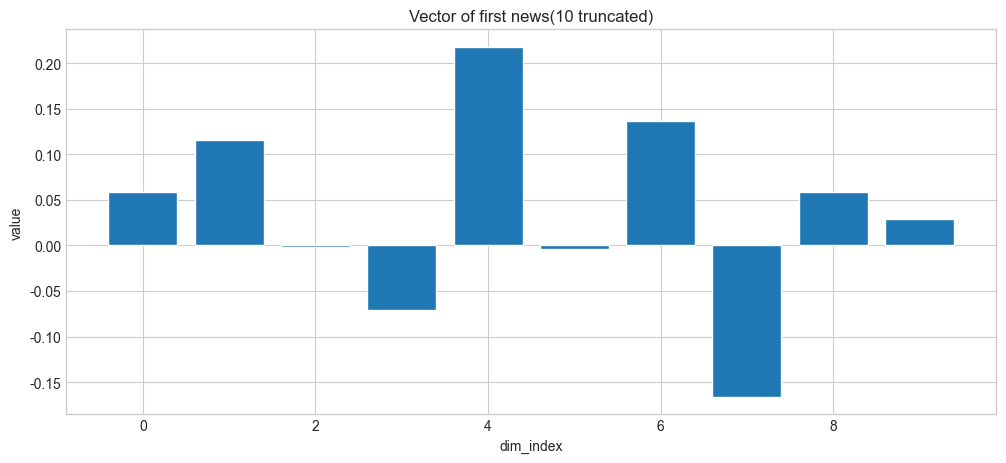

In [7]:
# 뉴스 벡터화기 초기화
news_vectorizer = NewsVectorizer(
    method='tfidf',
    max_features=10000,
    embedding_dim=300,
    use_gpu=True,
    title_weight=2.0
)

# 벡터화 수행
print("뉴스 기사 벡터화 중...")
vectorized_df = news_vectorizer.vectorize_articles(
    preprocessed_df,
    content_col='processed_content',
    title_col='processed_title',
    combine_title_content=True,
    reduce_dims=True,
    n_components=100
)

print("벡터화 완료")
print(f"벡터화된 기사: {len(vectorized_df)}개")

# 벡터 차원 확인
vector_sample = vectorized_df['vector'].iloc[0]
print(f"벡터 차원: {len(vector_sample)}")

# 벡터 시각화 (처음 10개 차원)
plt.figure(figsize=(12, 5))
plt.bar(range(10), vector_sample[:10])
plt.title('Vector of first news(10 truncated)')
plt.xlabel('dim_index')
plt.ylabel('value')
plt.show()

### 벡터 유사도 시각화

기사 간의 유사도를 시각화하여 벡터화의 효과를 확인합니다.

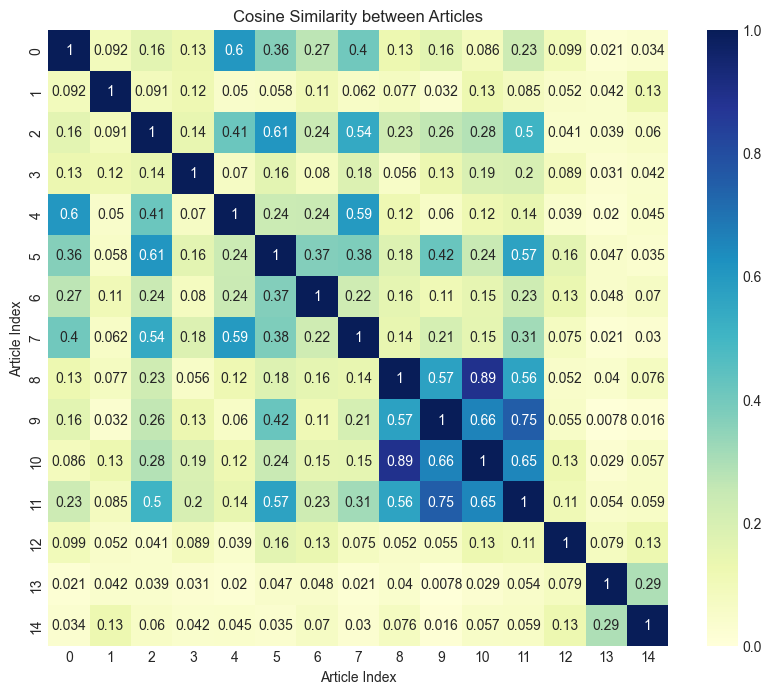

가장 유사한 기사 쌍: 8번과 10번 (유사도: 0.8888)

기사 8번 제목: [영상] 이재용·정의선·최태원·구광모, 처음으로 한자리에, URL: https://www.yna.co.kr/view/AKR20190102147800704
기사 10번 제목: '세대교체' 4대 기업 총수, 신년회서 처음으로 한 자리 '눈길'(종합), URL: https://www.yna.co.kr/view/AKR20190102080851003


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# 샘플 기사 선택 (처음 10개)
sample_vectors = np.array(vectorized_df['vector'].iloc[:15].tolist())

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(sample_vectors)

# 유사도 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Cosine Similarity between Articles')
plt.xlabel('Article Index')
plt.ylabel('Article Index')
plt.show()

# 가장 유사한 기사 쌍 찾기
np.fill_diagonal(similarity_matrix, 0)  # 자기 자신과의 유사도 제외
max_sim_idx = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
print(f"가장 유사한 기사 쌍: {max_sim_idx[0]}번과 {max_sim_idx[1]}번 (유사도: {similarity_matrix[max_sim_idx]:.4f})")

# 유사한 기사 제목 출력
print(f"\n기사 {max_sim_idx[0]}번 제목: {vectorized_df['Title'].iloc[max_sim_idx[0]]}, URL: {vectorized_df['Link'].iloc[max_sim_idx[0]]}")
print(f"기사 {max_sim_idx[1]}번 제목: {vectorized_df['Title'].iloc[max_sim_idx[1]]}, URL: {vectorized_df['Link'].iloc[max_sim_idx[1]]}")

## 4. 뉴스 클러스터링

벡터화된 뉴스 기사를 클러스터링하여 유사한 기사를 그룹화합니다. 이 단계에서는 다음 작업을 수행합니다:
- 계층적 응집 클러스터링 (HAC) 적용
- 클러스터 주제 생성
- 트렌드 클러스터 식별

### 클러스터링 알고리즘 설명

계층적 응집 클러스터링(HAC)은 네이버 AiRs 시스템에서도 사용하는 방법으로, 다음과 같은 단계로 진행됩니다:
1. 각 기사를 개별 클러스터로 시작
2. 가장 유사한 두 클러스터를 병합
3. 거리 임계값에 도달할 때까지 2단계 반복

거리 계산 공식 (코사인 거리):
- $distance(A, B) = 1 - \frac{A \cdot B}{||A|| \cdot ||B||}$

여기서 $A$와 $B$는 기사 벡터입니다.

2025-03-30 22:29:51,333 - src.models.news_clustering - INFO - Initialized NewsClustering with distance_threshold=0.7, min_cluster_size=2
2025-03-30 22:29:51,334 - src.models.news_clustering - INFO - Clustering 32208 articles


뉴스 기사 클러스터링 중...


2025-03-30 22:30:30,018 - src.models.news_clustering - INFO - Splitting 42 large clusters
2025-03-30 22:30:33,337 - src.models.news_clustering - INFO - Split large clusters, now have 1322 clusters
2025-03-30 22:30:39,608 - src.models.news_clustering - INFO - Clustering silhouette score: 0.1492
2025-03-30 22:30:39,609 - src.models.news_clustering - INFO - Created 1322 valid clusters
2025-03-30 22:30:39,614 - src.models.news_clustering - INFO - Saved clustering results to /Users/hwangchiung/CLEAR/models/clustering/clustering_results_20250330_223039.joblib


클러스터링 완료
생성된 클러스터 수: 1323

클러스터 크기 분포:


cluster_id
-1     307
 42     37
 43     93
 44     47
 45     30
 46      5
 47     16
 48     17
 49     25
 50      4
Name: count, dtype: int64

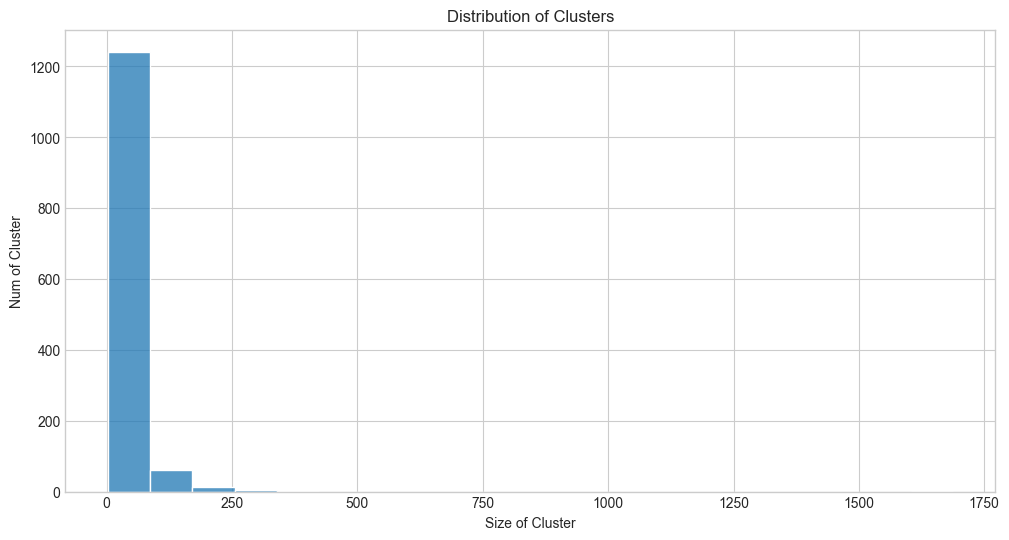

In [9]:
# 뉴스 클러스터링 초기화
news_clustering = NewsClustering(
    distance_threshold=0.7,  # 거리 임계값 (낮을수록 더 엄격한 클러스터링)
    min_cluster_size=2,      # 최소 클러스터 크기
    max_cluster_size=20,     # 최대 클러스터 크기
    linkage='average'        # 연결 방법 (평균 연결)
)

# 클러스터링 수행
print("뉴스 기사 클러스터링 중...")
clustered_df = news_clustering.cluster_articles(
    vectorized_df,
    vector_col='vector',
    title_col='Title',
    content_col='Body'
)

print("클러스터링 완료")
print(f"생성된 클러스터 수: {clustered_df['cluster_id'].nunique()}")

# 클러스터 크기 분포
cluster_sizes = clustered_df['cluster_id'].value_counts().sort_index()
print("\n클러스터 크기 분포:")
display(cluster_sizes.head(10))

# 클러스터 크기 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes.values, bins=20)
plt.title('Distribution of Clusters')
plt.xlabel('Size of Cluster')
plt.ylabel('Num of Cluster')
plt.show()

### 클러스터 주제 및 내용 확인

생성된 클러스터의 주제와 포함된 기사를 확인합니다.

In [10]:
# 클러스터 주제 확인
cluster_topics = clustered_df.groupby('cluster_id')['cluster_topic'].first()
print("클러스터 주제 샘플:")
display(cluster_topics.head(5))

# 클러스터별 크기 확인
cluster_sizes = clustered_df['cluster_id'].value_counts()

# 특정 클러스터 기사 확인 (가장 큰 클러스터 예시)
sample_cluster_id = cluster_sizes.index[0]
sample_cluster = clustered_df[clustered_df['cluster_id'] == sample_cluster_id]

print(f"\n클러스터 {sample_cluster_id}번 (주제: {sample_cluster['cluster_topic'].iloc[0]})의 기사:")
display(sample_cluster[['Title', 'Date', 'Press']].head())

클러스터 주제 샘플:


cluster_id
-1                       
 42    스마트폰 점유율 화웨이 시장 작년
 43     스마트폰 삼성 1위 점유율 세계
 44    1위 tv 글로벌 삼성전자 점유율
 45      인도 삼성 인도서 샤오미 1위
Name: cluster_topic, dtype: object


클러스터 80번 (주제: 삼성전자 종합 삼성 ai 등)의 기사:


,Title,Date,Press
9783,"구글 클라우드 쓰는 삼성 빅스비…""AI 학습 속도 18배 향상""",20201021 10:48,yna
9880,"삼성SDS, 무디스 신용평가 A1 등급 취득",20201025 09:54,yna
10001,"삼성전자 인공인간 프로젝트 '네온', CJ와 손잡았다",20201029 09:20,yna
10095,인공지능과 대화하며 금융상담…신한은행-삼성전자 협력,20201105 10:30,yna
10197,대한항공·아시아나항공 통합해 세계7위 '메가캐리어' 탄생한다,20201116 11:17,yna


### 트렌드 클러스터 식별

최근 24시간 내에 많은 기사가 포함된 클러스터를 트렌드 클러스터로 식별합니다. -> YNA 데이터 특성상 충분한 기사 클러스터가 없을 수 있음!

In [11]:
# 트렌드 클러스터 식별 -> 기사 수 확보 위해 500시간 세팅
trending_clusters = news_clustering.get_trending_clusters(
    clustered_df,
    timeframe_hours=500,
    min_articles=2
)

print(f"식별된 트렌드 클러스터: {len(trending_clusters)}개")

print("\n트렌드 클러스터 주제:")
for cluster_id in trending_clusters:
    topic = clustered_df.loc[clustered_df['cluster_id'] == cluster_id, 'cluster_topic'].iloc[0]
    count = (clustered_df['cluster_id'] == cluster_id).sum()
    print(f"클러스터 {cluster_id}번: {topic} (기사 {count}개)")

2025-03-30 22:30:39,746 - src.models.news_clustering - INFO - Identifying trending clusters in the last 500 hours
2025-03-30 22:30:40,737 - src.models.news_clustering - INFO - Identified 19 trending clusters


식별된 트렌드 클러스터: 19개

트렌드 클러스터 주제:
클러스터 80번: 삼성전자 종합 삼성 ai 등 (기사 1688개)
클러스터 89번: 반도체 용인 종합 용인시 추진 (기사 159개)
클러스터 1287번: 트럼프 종합 관세 美 마켓뷰 (기사 162개)
클러스터 735번: 지수선물·옵션 코스피 표 -2 시세표 (기사 6개)
클러스터 980번: 코스피 종합 2 올라 상승 (기사 96개)
클러스터 800번: 상위종목 순매수도 거래소 표 외국인 (기사 75개)
클러스터 187번: 직원 삼성전자 연봉 평균연봉 작년 (기사 38개)
클러스터 1299번: 삼성전자 사외이사 종합 선임 등 (기사 40개)
클러스터 107번: 할인 주말n쇼핑 롯데하이마트 최대 행사 (기사 139개)
클러스터 963번: 종합 코스피 2 마감 1 (기사 31개)
클러스터 1048번: 특징주 종합 반도체株 강세 마켓톺 (기사 9개)
클러스터 94번: 삼성전자 외국인 코스피 시총 순매수 (기사 196개)
클러스터 990번: 코스피 2 장중 오름폭 키워 (기사 92개)
클러스터 266번: 재발한 경기불안 제물 된 엔비디아…반도체株 호시절 가나 (기사 4개)
클러스터 217번: 삼성전자 엔비디아 hbm 황 종합 (기사 45개)
클러스터 97번: 삼성전자 스마트싱스 삼성 스마트 구축 (기사 84개)
클러스터 987번: 코스피 2 장중 낙폭 하락 (기사 92개)
클러스터 1297번: 삼성전자 주총 자사주 소액주주 종합 (기사 76개)
클러스터 262번: 메모리 삼성전자 재고 종합 내년 (기사 33개)


## 5. 주가 영향 분석

뉴스 기사가 주가에 미치는 영향을 분석합니다. 이 단계는 네이버 AiRs의 개인화 구성 요소를 대체하는 CLEAR 시스템의 핵심 부분입니다.

### 영향 분석 방법 설명

주가 영향 분석은 다음 단계로 진행됩니다:
1. 각 뉴스 기사에 대해 발행 시간 식별
2. 여러 시간 윈도우(즉시, 단기, 중기)에서 주가 변화 계산
3. 가격 및 거래량 변화를 기반으로 영향 점수 계산

영향 점수 계산 공식:
- $Impact_{price} = \frac{Price_{after} - Price_{before}}{Price_{before}} \times 100$
- $Impact_{volume} = \frac{Volume_{after} - Volume_{avg}}{Volume_{avg}} \times 100$
- $Impact_{total} = w_{price} \times Impact_{price} + w_{volume} \times Impact_{volume}$

최종 영향 점수는 -5에서 +5 사이의 척도로 정규화됩니다.

### 주가 영향 분석 업데이트

주가 영향 분석기가 일별 주가 데이터를 올바르게 처리하도록 업데이트되었습니다:
- Time 열은 항상 0이므로 무시됩니다
- Start는 09:00 시장 개장 가격으로 처리됩니다
- End는 15:00 시장 마감 가격으로 처리됩니다
- 일별 가격 변동과 변동성을 기반으로 영향 점수가 계산됩니다

이 업데이트는 주가 데이터의 실제 구조를 정확히 반영합니다.

2025-03-30 22:30:40,748 - src.models.stock_impact_analyzer - WARNING - GPU requested but not available, falling back to CPU
2025-03-30 22:30:40,749 - src.models.stock_impact_analyzer - INFO - Initialized StockImpactAnalyzer with 3 time windows
2025-03-30 22:30:40,749 - src.models.stock_impact_analyzer - INFO - Analyzing impact for 32208 news articles


주가 영향 분석 중...
영향 분석 완료
영향 점수가 계산된 기사: 32208개


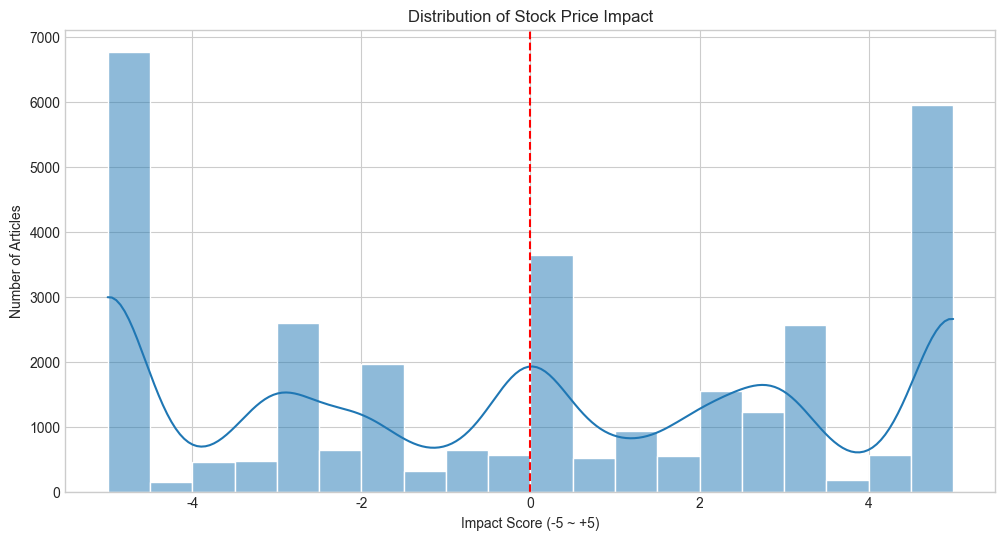


영향 점수 통계:


count    32208.000000
mean        -0.103002
std          3.612115
min         -5.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max          5.000000
Name: impact_score, dtype: float64

In [12]:
# 주가 영향 분석기 초기화
impact_analyzer = StockImpactAnalyzer(
    time_windows=[
        {"name": "immediate", "days": 1},
        {"name": "short_term", "days": 3},
        {"name": "medium_term", "days": 7}
    ],
    impact_thresholds={
        "high": 0.01,    # 2% 가격 변동
        "medium": 0.005,  # 1% 가격 변동
        "low": 0.0025     # 0.5% 가격 변동
    },
    use_gpu=True
)

# 영향 분석 수행
print("주가 영향 분석 중...")
impact_df = impact_analyzer.analyze_news_impact(
    clustered_df,
    stock_data
)

print("영향 분석 완료")
print(f"영향 점수가 계산된 기사: {len(impact_df.dropna(subset=['impact_score']))}개")

# 영향 점수 분포
plt.figure(figsize=(12, 6))
sns.histplot(impact_df['impact_score'].dropna(), bins=20, kde=True)
plt.title('Distribution of Stock Price Impact')
plt.xlabel('Impact Score (-5 ~ +5)')
plt.ylabel('Number of Articles')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# 영향 점수 통계
impact_stats = impact_df['impact_score'].describe()
print("\n영향 점수 통계:")
display(impact_stats)

### 영향 예측 모델 훈련

과거 데이터를 기반으로 뉴스 기사의 주가 영향을 예측하는 모델을 훈련합니다.

2025-03-30 22:32:12,289 - src.models.stock_impact_analyzer - INFO - Training random_forest impact prediction model on 32208 articles


영향 예측 모델 훈련 중...


2025-03-30 22:35:45,924 - src.models.stock_impact_analyzer - ERROR - Error training impact model: 'StockImpactAnalyzer' object has no attribute '_save_impact_model'
2025-03-30 22:35:45,929 - src.models.stock_impact_analyzer - INFO - Predicting impact for 32208 articles
2025-03-30 22:35:47,043 - src.models.stock_impact_analyzer - INFO - Predicted impact for 32208 articles


예측 완료
예측된 영향 점수가 있는 기사: 32208개


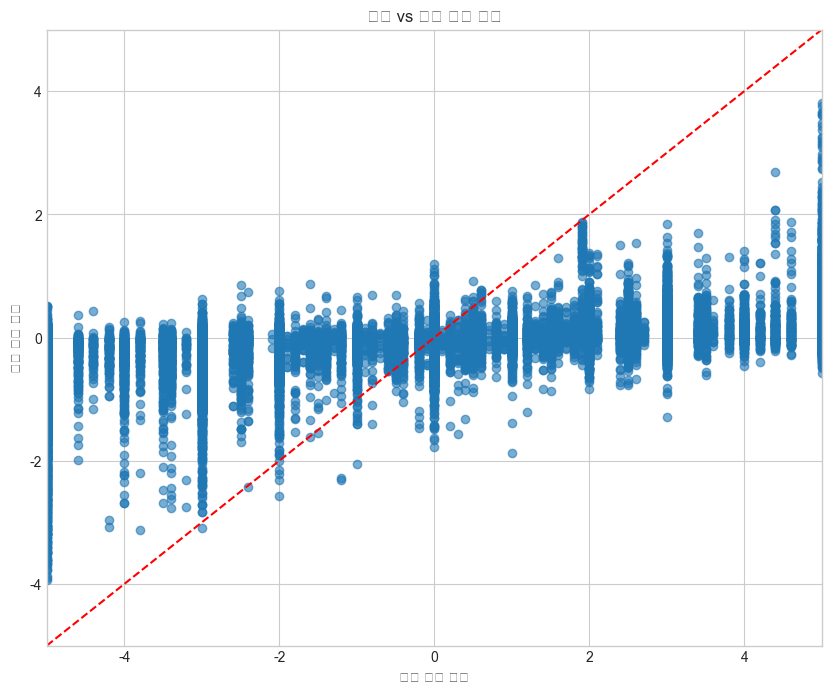


예측 성능 지표:
RMSE: 3.3616
MAE: 2.9224
R²: 0.1338


In [13]:
# 영향 예측 모델 훈련
print("영향 예측 모델 훈련 중...")
impact_analyzer.train_impact_model(
    impact_df,
    stock_data,
    model_type='random_forest'
)

# 예측 수행
impact_df = impact_analyzer.predict_impact(
    impact_df,
    # include_features=True
)

print("예측 완료")
print(f"예측된 영향 점수가 있는 기사: {len(impact_df.dropna(subset=['predicted_impact']))}개")

# 실제 vs 예측 영향 점수 비교
valid_impact_df = impact_df.dropna(subset=['impact_score', 'predicted_impact'])

plt.figure(figsize=(10, 8))
plt.scatter(valid_impact_df['impact_score'], valid_impact_df['predicted_impact'], alpha=0.6)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.title('실제 vs 예측 영향 점수')
plt.xlabel('실제 영향 점수')
plt.ylabel('예측 영향 점수')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(True)
plt.show()

# 예측 성능 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = valid_impact_df['impact_score']
y_pred = valid_impact_df['predicted_impact']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n예측 성능 지표:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

### 주가 영향 시각화

뉴스 기사와 주가 변동 간의 관계를 시각화합니다.

In [14]:
# 주가 영향 시각화
ticker = '005930'  # 삼성전자
viz_path = impact_analyzer.visualize_impact(
    impact_df,
    stock_data,
    ticker,
    # save_path=None  # 저장하지 않고 직접 표시
)

# 시각화된 이미지 경로 출력
print(f"시각화 이미지 저장 경로: {viz_path}")

# 영향이 큰 상위 기사 확인
print("\n영향이 가장 큰 긍정적 기사 (상위 3개):")
display(impact_df.sort_values('impact_score', ascending=False)[['Title', 'Date', 'impact_score']].head(3))

print("\n영향이 가장 큰 부정적 기사 (상위 3개):")
display(impact_df.sort_values('impact_score')[['Title', 'Date', 'impact_score']].head(3))

2025-03-30 22:35:47,229 - src.models.stock_impact_analyzer - WARNING - Impact column impact_{'005930':            Date  Time  Start   High    Low    End    Volume  \
0    2025-03-05     0  55100  55400  54200  54300   6367338   
1    2025-03-04     0  53900  55000  53800  54500  18553933   
2    2025-02-28     0  55400  55700  54500  54500  28036698   
3    2025-02-27     0  56500  57100  56200  56300  14975356   
4    2025-02-26     0  57000  57100  56100  56600  18117091   
...         ...   ...    ...    ...    ...    ...       ...   
2851 2013-07-22     0  25600  25780  25300  25460  10351150   
2852 2013-07-19     0  25760  25900  25280  25460  16271300   
2853 2013-07-18     0  26500  26500  25840  25840  15704200   
2854 2013-07-17     0  26020  26600  25720  26400  12302300   
2855 2013-07-16     0  26360  26420  25800  25960   9300950   

                datetime        date  
0    2025-03-05 09:00:00  2025-03-05  
1    2025-03-04 09:00:00  2025-03-04  
2    2025-02-28 09:00:0

시각화 이미지 저장 경로: None

영향이 가장 큰 긍정적 기사 (상위 3개):


,Title,Date,impact_score
16104,농협은행 삼성디지털시티지점 개점…혁신금융기술 특화,2022-02-09,5.0
18181,"코스피 하락 출발해 보합권…2,400선 지지(종합)",2022-07-27,5.0
5305,[표] 거래소 기관 순매수도 상위종목(22일),2019-11-22,5.0



영향이 가장 큰 부정적 기사 (상위 3개):


,Title,Date,impact_score
23733,"삼성전자, 현존 최대 용량 32Gb DDR5 D램 개발…""연내 양산""",2023-09-01,-5.0
19291,"잇단 빅스텝 여파…기업들 ""이자 감당할 임계치 벗어났다""",2022-10-12,-5.0
19290,[연합뉴스 이 시각 헤드라인] - 14:30,2022-10-12,-5.0


## 6. 뉴스 추천

주가 영향 및 기타 요소를 기반으로 뉴스 기사를 추천합니다. 이 단계에서는 네이버 AiRs의 다중 요소 접근 방식을 유지하되, 개인화 대신 주가 영향에 중점을 둡니다.

### 추천 알고리즘 설명

CLEAR 추천 시스템은 다음 5가지 요소를 기반으로 점수를 계산합니다:
1. **주가 영향(SI)**: AiRs의 사회적 관심도를 대체하여 중요한 재무적 영향이 있는 기사 우선순위
2. **품질 평가(QE)**: 클러스터 크기 및 기타 지표를 기사 품질의 대리 지표로 사용
3. **콘텐츠 기반 필터링(CBF)**: 인기 있는 금융 기사와의 유사성 측정
4. **협업 필터링(CF)**: 기사 관계에 NPMI(정규화된 점별 상호 정보량) 사용
5. **최신**: 시기적절한 추천을 보장하기 위해 최근 기사 우선순위

최종 추천 점수 계산 공식:
- $Score = w_{impact} \times SI + w_{quality} \times QE + w_{content} \times CBF + w_{collaborative} \times CF + w_{recency} \times Latest$

In [15]:
# 뉴스 추천기 초기화
news_recommender = NewsRecommender(
    weights={
        'impact': 0.4,      # 주가 영향(SI)
        'quality': 0.2,     # 품질 평가(QE)
        'content': 0.2,     # 콘텐츠 기반 필터링(CBF)
        'collaborative': 0.1, # 협업 필터링(CF)
        'recency': 0.1      # 최신 뉴스 우선순위
    }
)

# 기사 추천 생성
print("뉴스 추천 생성 중...")
top_articles = news_recommender.recommend_articles(
    impact_df,
    top_n=10
)

print("추천 생성 완료")
print(f"추천된 기사: {len(top_articles)}개")

# 추천 기사 확인
print("\n추천 기사 목록:")
display(top_articles[['Title', 'Date', 'recommendation_score', 'impact_score', 'cluster_topic']].head(10))

2025-03-30 22:35:47,314 - src.models.news_recommender - INFO - Initialized NewsRecommender with weights: {'impact': 0.4, 'quality': 0.2, 'content': 0.2, 'collaborative': 0.1, 'recency': 0.1}
2025-03-30 22:35:47,315 - src.models.news_recommender - INFO - Generating recommendations from 32208 articles
2025-03-30 22:35:47,374 - src.models.news_recommender - INFO - Generated 10 recommendations
2025-03-30 22:35:47,376 - src.models.news_recommender - INFO - Saved recommendations to /Users/hwangchiung/CLEAR/models/recommender/recommendations_20250330_223547.joblib


뉴스 추천 생성 중...
추천 생성 완료
추천된 기사: 10개

추천 기사 목록:


,Title,Date,recommendation_score,impact_score,cluster_topic
32202,전례 없는 사모펀드 회장 사재출연…홈플러스 회생 돌파구 될까(종합),2025-03-16,0.314923,0.0,삼성전자 종합 삼성 ai 등
32198,"KB증권 ""양자컴퓨터 현실화…삼성전자·LG전자·SK텔레콤 수혜""",2025-03-14,0.228457,0.0,삼성전자 종합 삼성 ai 등
32197,"서울시, 기업과 손잡고 자립준비청년 지원…6억원 긴급자금 조성",2025-03-14,0.228457,0.0,삼성전자 종합 삼성 ai 등
32195,"크래프톤, 배틀그라운드 8주년 기념 서울서 팬 축제",2025-03-14,0.228457,0.0,삼성전자 종합 삼성 ai 등
32194,"서울시, 기업과 손잡고 자립준비청년 지원…6억원 긴급자금 조성(종합)",2025-03-14,0.228457,0.0,삼성전자 종합 삼성 ai 등
32178,"용인시, 삼성전자 앞 도로 '윌리엄슨카운티대로' 명예도로명",2025-03-13,0.219902,0.0,삼성전자 종합 삼성 ai 등
32184,거대언어모델 학습시간 단축 시뮬레이션 기술 오픈소스로 공개,2025-03-13,0.219902,0.0,삼성전자 종합 삼성 ai 등
32205,주총장 개방하고 영어 동시통역까지…기업들 '열린 주총' 확대,2025-03-16,0.219426,0.0,삼성전자 주총 자사주 소액주주 종합
32204,"삼성 네오 QLED 8K·네오 QLED, 5년 연속 '탄소저감' 인증 획득",2025-03-16,0.217767,0.0,인증 획득 삼성 삼성전자 tv
32206,"LG·삼성전자, 미국서 세탁기 이어 냉장고도 소비자 평가 1위",2025-03-16,0.217530,0.0,선정 lg전자 최고의 컨슈머리포트 최고


### 클러스터 기반 추천

클러스터 단위로 추천을 생성하여 다양한 주제의 뉴스를 제공합니다.

In [16]:
# 클러스터 추천 생성
top_clusters = news_recommender.recommend_clusters(
    impact_df,
    top_n=5,
    articles_per_cluster=3
)

print(f"추천된 클러스터: {len(top_clusters)}개")

# 각 클러스터의 추천 기사 확인
for cluster_id, cluster_df in top_clusters.items():
    cluster_topic = cluster_df['cluster_topic'].iloc[0]
    print(f"\n클러스터 {cluster_id}번 (주제: {cluster_topic})의 추천 기사:")
    display(cluster_df[['Title', 'Date', 'article_score', 'impact_score']].head(3))

2025-03-30 22:35:47,387 - src.models.news_recommender - INFO - Generating cluster recommendations from 32208 articles
2025-03-30 22:35:47,892 - src.models.news_recommender - INFO - Generated recommendations for 5 clusters
2025-03-30 22:35:47,896 - src.models.news_recommender - INFO - Saved cluster recommendations to /Users/hwangchiung/CLEAR/models/recommender/cluster_recommendations_20250330_223547.joblib


추천된 클러스터: 5개

클러스터 80번 (주제: 삼성전자 종합 삼성 ai 등)의 추천 기사:


,Title,Date,article_score,impact_score
32202,전례 없는 사모펀드 회장 사재출연…홈플러스 회생 돌파구 될까(종합),2025-03-16,0.314923,0.0
32198,"KB증권 ""양자컴퓨터 현실화…삼성전자·LG전자·SK텔레콤 수혜""",2025-03-14,0.228457,0.0
32197,"서울시, 기업과 손잡고 자립준비청년 지원…6억원 긴급자금 조성",2025-03-14,0.228457,0.0



클러스터 1297번 (주제: 삼성전자 주총 자사주 소액주주 종합)의 추천 기사:


,Title,Date,article_score,impact_score
32205,주총장 개방하고 영어 동시통역까지…기업들 '열린 주총' 확대,2025-03-16,0.314923,0.0
32120,삼성전자 '소액주주 500만' 다시 넘었다…1년새 49만명↑,2025-03-11,0.215597,0.0
32064,"거버넌스포럼 ""재계, 상법개정 반대 위해 소송우려 의도적 과장""",2025-03-06,0.214928,0.0



클러스터 105번 (주제: 인증 획득 삼성 삼성전자 tv)의 추천 기사:


,Title,Date,article_score,impact_score
32204,"삼성 네오 QLED 8K·네오 QLED, 5년 연속 '탄소저감' 인증 획득",2025-03-16,0.314923,0.0
11659,"삼성 네오 QLED TV, 독일 인증기관서 '눈 안전성' 인증 획득",2021-03-11,0.214923,-5.0
21452,"삼성전자, 국내 첫 '국제수자원관리동맹' 최고 등급 인증 받아(종합)",2023-03-22,0.214923,5.0



클러스터 1198번 (주제: 선정 lg전자 최고의 컨슈머리포트 최고)의 추천 기사:


,Title,Date,article_score,impact_score
32206,"LG·삼성전자, 미국서 세탁기 이어 냉장고도 소비자 평가 1위",2025-03-16,0.314923,0.0
32116,"LG 세탁기·건조기, 美 소비자평가 2개 부문 1위…삼성도 1개",2025-03-10,0.215171,0.0
23356,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",2023-08-01,0.214923,2.0



클러스터 951번 (주제: 경보 20㎞ 김현섭 -세계육상- 도쿄올림픽)의 추천 기사:


,Title,Date,article_score,impact_score
32203,"김홍록, 서울마라톤 남자 국내부 2연패…2시간12분29초",2025-03-16,0.314923,0.0
31840,세계 최고수준 우승상금 '2025 대구마라톤대회' 23일 개최,2025-02-19,0.214923,-5.0
4532,-세계육상- 20㎞ 경보 김현섭 37위…최병광은 21위(종합),2019-10-05,0.214923,3.0


### 트렌드 주제 추천

현재 트렌드인 주제를 추천합니다.

In [17]:
# 트렌드 주제 추천
trending_topics = news_recommender.recommend_trending_topics(
    impact_df,
    top_n=10
)

print(f"추천된 트렌드 주제: {len(trending_topics)}개")
print("\n트렌드 주제 목록:")
for i, topic in enumerate(trending_topics, 1):
    print(f"{i}. {topic['topic']} (점수: {topic['score']:.2f})")

2025-03-30 22:35:47,915 - src.models.news_recommender - INFO - Identifying trending topics from 32208 articles
2025-03-30 22:35:48,465 - src.models.news_recommender - INFO - Identified 10 trending topics


추천된 트렌드 주제: 10개

트렌드 주제 목록:
1. 삼성전자 종합 삼성 ai 등 (점수: 0.61)
2. 삼성전자 주총 자사주 소액주주 종합 (점수: 0.60)
3. 인증 획득 삼성 삼성전자 tv (점수: 0.60)
4. 선정 lg전자 최고의 컨슈머리포트 최고 (점수: 0.60)
5. 경보 20㎞ 김현섭 -세계육상- 도쿄올림픽 (점수: 0.60)
6. 효자 침체 삼성·lg 전장사업 실적 (점수: 0.60)
7. 삼성전자 외국인 코스피 시총 순매수 (점수: 0.22)
8. 할인 주말n쇼핑 롯데하이마트 최대 행사 (점수: 0.22)
9. 상위종목 순매수도 거래소 표 외국인 (점수: 0.08)
10. 상위종목 순매수도 거래소 표 기관 (점수: 0.08)


## 7. 결과 시각화 및 평가

시스템의 성능을 평가하고 결과를 시각화합니다.

In [18]:
# 평가기 초기화
evaluator = CLEAREvaluator(results_dir="results/evaluation")

# 클러스터링 평가
print("클러스터링 평가 중...")
clustering_metrics = evaluator.evaluate_clustering(
    impact_df,
    vector_col='vector',
    cluster_col='cluster_id'
)

print("\n클러스터링 평가 지표:")
for metric, value in clustering_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# 영향 예측 평가
print("\n영향 예측 평가 중...")
impact_metrics = evaluator.evaluate_impact_prediction(
    impact_df,
    actual_col='impact_score',
    predicted_col='predicted_impact'
)

print("\n영향 예측 평가 지표:")
for metric, value in impact_metrics.items():
    print(f"{metric}: {value:.4f}")

# 추천 평가
print("\n추천 평가 중...")
recommendations = {
    'top_articles': top_articles,
    'top_clusters': top_clusters,
    'trending_topics': trending_topics
}
recommendation_metrics = evaluator.evaluate_recommendations(recommendations)

print("\n추천 평가 지표:")
for metric, value in recommendation_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

2025-03-30 22:35:48,474 - src.evaluation - INFO - Initialized CLEAR evaluator
2025-03-30 22:35:48,475 - src.evaluation - INFO - Evaluating clustering quality for 32208 articles


클러스터링 평가 중...


2025-03-30 22:35:55,529 - src.evaluation - INFO - Calculated clustering metrics: {'silhouette_score': 0.14923384695159464, 'calinski_harabasz_score': 120.46749526543053, 'davies_bouldin_score': 1.5787367907242296, 'num_clusters': 1322, 'avg_cluster_size': 24.13086232980333, 'max_cluster_size': 1688, 'min_cluster_size': 2}
2025-03-30 22:35:55,541 - src.evaluation - ERROR - Error saving metrics: Object of type int64 is not JSON serializable
2025-03-30 22:35:55,554 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 22:35:55,572 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 22:36:09,570 - src.evaluation - INFO - Created clusterin


클러스터링 평가 지표:
silhouette_score: 0.1492
calinski_harabasz_score: 120.4675
davies_bouldin_score: 1.5787
num_clusters: 1322
avg_cluster_size: 24.1309
max_cluster_size: 1688
min_cluster_size: 2

영향 예측 평가 중...


2025-03-30 22:36:10,188 - src.evaluation - INFO - Created impact prediction visualizations
2025-03-30 22:36:10,191 - src.evaluation - INFO - Evaluating recommendation quality
2025-03-30 22:36:10,192 - src.evaluation - INFO - Calculated recommendation metrics: {'num_recommended_articles': 10, 'avg_impact_score': 0.0, 'max_impact_score': 0.0, 'min_impact_score': 0.0, 'unique_clusters_in_recommendations': 4, 'num_recommended_clusters': 5, 'num_trending_topics': 10}
2025-03-30 22:36:10,193 - src.evaluation - INFO - Saved recommendations metrics to results/evaluation/recommendations_metrics_20250330_223610.json



영향 예측 평가 지표:
mean_squared_error: 11.3007
root_mean_squared_error: 3.3616
mean_absolute_error: 2.9224
r2_score: 0.1338
direction_accuracy: 0.6988

추천 평가 중...

추천 평가 지표:
num_recommended_articles: 10
avg_impact_score: 0.0000
max_impact_score: 0.0000
min_impact_score: 0.0000
unique_clusters_in_recommendations: 4
num_recommended_clusters: 5
num_trending_topics: 10


### 종합 결과 시각화

시스템의 주요 결과를 종합적으로 시각화합니다.

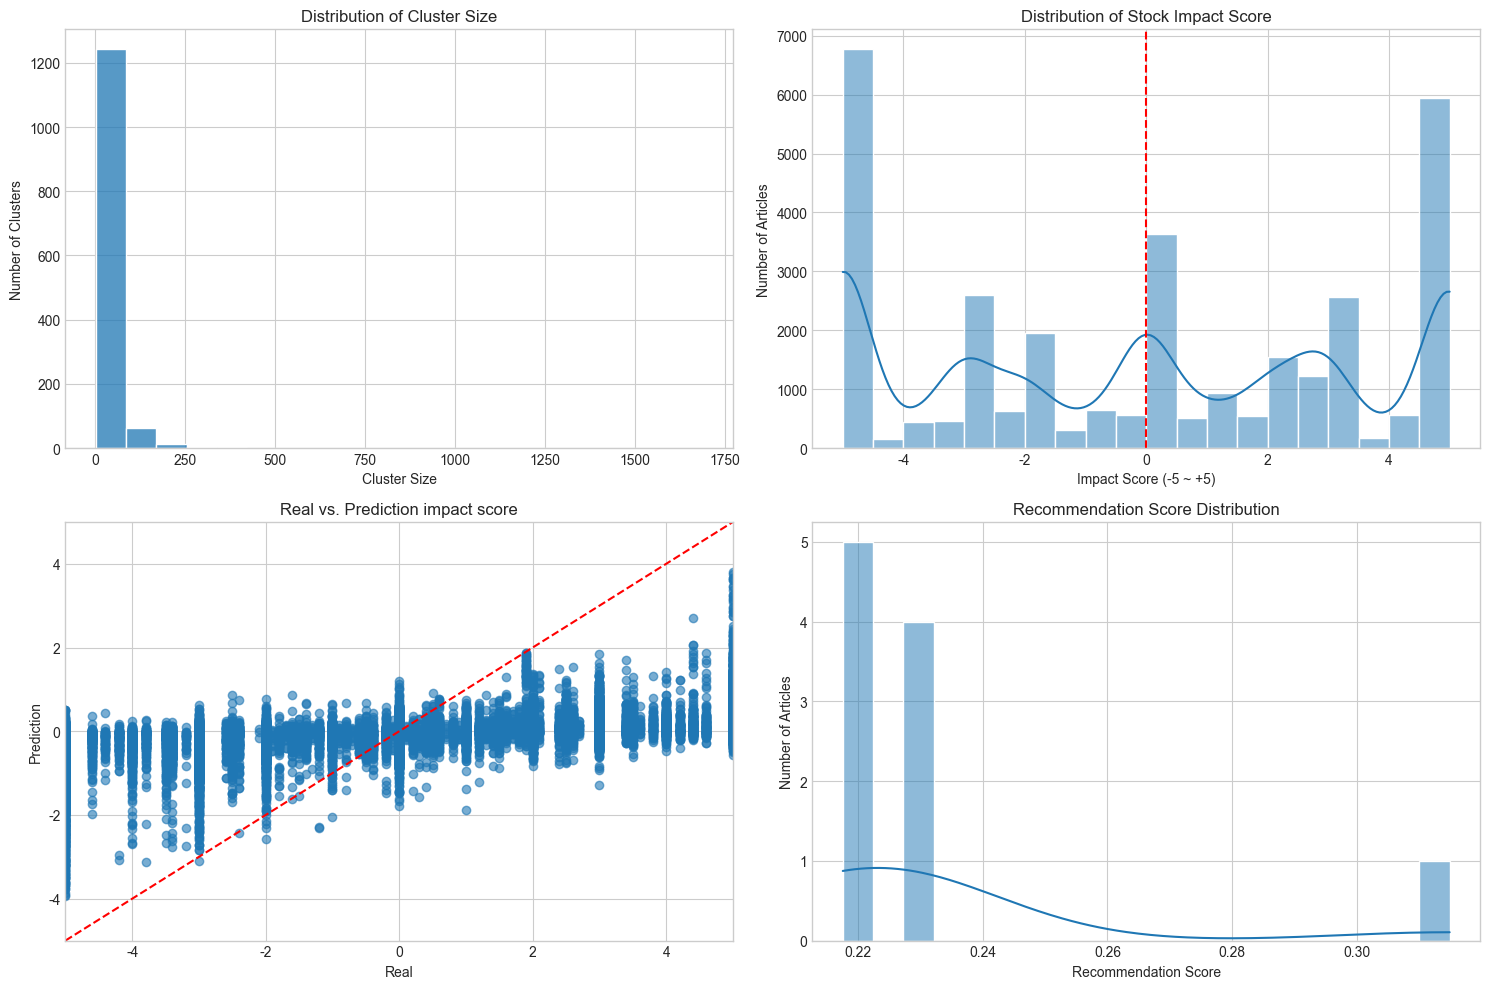

In [19]:
# 종합 결과 시각화
plt.figure(figsize=(15, 10))

# 1. 클러스터 크기 분포
plt.subplot(2, 2, 1)
sns.histplot(cluster_sizes.values, bins=20)
plt.title('Distribution of Cluster Size')
plt.xlabel('Cluster Size')
plt.ylabel('Number of Clusters')

# 2. 영향 점수 분포
plt.subplot(2, 2, 2)
sns.histplot(impact_df['impact_score'].dropna(), bins=20, kde=True)
plt.title('Distribution of Stock Impact Score')
plt.xlabel('Impact Score (-5 ~ +5)')
plt.ylabel('Number of Articles')
plt.axvline(x=0, color='r', linestyle='--')

# 3. 실제 vs 예측 영향 점수
plt.subplot(2, 2, 3)
plt.scatter(valid_impact_df['impact_score'], valid_impact_df['predicted_impact'], alpha=0.6)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.title('Real vs. Prediction impact score')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(True)

# 4. 추천 점수 분포
plt.subplot(2, 2, 4)
sns.histplot(top_articles['recommendation_score'], bins=20, kde=True)
plt.title('Recommendation Score Distribution')
plt.xlabel('Recommendation Score')
plt.ylabel('Number of Articles')

plt.tight_layout()
plt.show()

## 결론

이 노트북에서는 CLEAR 시스템의 각 모듈을 단계별로 시연했습니다. CLEAR는 네이버의 AiRs 아키텍처를 기반으로 하되, 개인화 대신 주가 영향에 중점을 둔 뉴스 추천 시스템입니다.

주요 구성 요소:
1. **텍스트 전처리**: Mecab을 사용한 한국어 형태소 분석 및 불용어 제거
2. **뉴스 벡터화**: TF-IDF 및 기타 임베딩 방법을 사용한 벡터 표현 생성
3. **뉴스 클러스터링**: 계층적 응집 클러스터링을 사용한 유사 기사 그룹화
4. **주가 영향 분석**: 뉴스 기사가 주가에 미치는 영향 측정 및 예측
5. **뉴스 추천**: 주가 영향 및 기타 요소를 기반으로 한 다중 요소 추천

CLEAR 시스템은 AiRs의 핵심 메커니즘을 유지하면서 금융 도메인에 맞게 조정되어, 투자자와 금융 분석가에게 가치 있는 도구를 제공합니다.

# 고급 기능 데모 (Advanced Features Demonstration)

이 섹션에서는 CLEAR 시스템의 고급 기능을 시연합니다:

1. **KO-finbert를 이용한 감성 분석**: 한국어 금융 텍스트의 감성 분석
2. **다양한 한국어 임베딩 모델**: 허깅페이스(Hugging Face)의 여러 한국어 모델 활용
3. **다양한 점수 산출 방법**: 앙상블 접근법을 통한 종합적인 점수 산출
4. **고급 주가 영향 분석 기법**: 변동성 기반 영향 점수 산출 및 시장 트렌드 상관관계 분석

This section demonstrates the advanced features of the CLEAR system:

1. **KO-finbert for Sentiment Analysis**: Sentiment analysis of Korean financial texts
2. **Multiple Korean Language Embedding Models**: Utilizing various Korean models from Hugging Face
3. **Diverse Scoring Methods**: Comprehensive scoring through ensemble approaches
4. **Advanced Stock Impact Analysis Techniques**: Volatility-based impact scoring and market trend correlation analysis

# 고급 모델 가져오기 (Import Advanced Models)

CLEAR 시스템의 고급 기능을 제공하는 모델들을 가져옵니다.

Import the models that provide advanced functionality for the CLEAR system.

In [20]:
from src.models.korean_text_analyzer import KoreanFinancialTextAnalyzer
from src.models.korean_embedding_enhancer import KoreanEmbeddingEnhancer
from src.models.advanced_scoring_methods import AdvancedScoringMethods
from src.models.advanced_stock_impact_analyzer import AdvancedStockImpactAnalyzer

print("고급 모델 가져오기 완료 (Advanced models imported successfully)")

고급 모델 가져오기 완료 (Advanced models imported successfully)


# 한국어 금융 텍스트 분석기 초기화 (Initialize Korean Financial Text Analyzer)

KO-finbert를 이용한 한국어 금융 텍스트 감성 분석기를 초기화합니다.

Initialize the Korean financial text analyzer with KO-finbert for sentiment analysis.

In [21]:
# KO-finbert를 이용한 한국어 금융 텍스트 분석기 초기화
# Initialize Korean financial text analyzer with KO-finbert
text_analyzer = KoreanFinancialTextAnalyzer(
    use_finbert=True,  # KO-finbert 사용 (Use KO-finbert)
    use_advanced_embeddings=False,  # 고급 임베딩 사용 안 함 (Don't use advanced embeddings)
    cache_results=True  # 결과 캐싱 (Cache results)
)

print("한국어 금융 텍스트 분석기 초기화 완료 (Korean financial text analyzer initialized)")

2025-03-30 22:36:11,554 - src.models.korean_text_analyzer - INFO - Loading KO-finbert model: snunlp/KR-FinBert-SC
2025-03-30 22:36:13,598 - src.models.korean_text_analyzer - INFO - KO-finbert model loaded successfully
2025-03-30 22:36:13,600 - src.models.korean_text_analyzer - INFO - Loaded analysis cache with 600 entries
2025-03-30 22:36:13,601 - src.models.korean_text_analyzer - INFO - Initialized KoreanFinancialTextAnalyzer with finbert=True, advanced_embeddings=False


한국어 금융 텍스트 분석기 초기화 완료 (Korean financial text analyzer initialized)


# 한국어 금융 텍스트 분석 (Analyze Korean Financial Text)

뉴스 데이터에서 샘플 텍스트를 선택하여 감성 분석을 수행합니다.

Select sample texts from the news data and perform sentiment analysis.

In [22]:
# 뉴스 데이터에서 샘플 텍스트 선택 (Select sample texts from news data)
sample_texts = []
for i in range(min(5, len(news_df))):
    title = news_df.iloc[i]['Title']
    sample_texts.append(title)

print("샘플 텍스트 (Sample texts):")
for i, text in enumerate(sample_texts):
    print(f"{i+1}. {text}")

print("\n감성 분석 결과 (Sentiment analysis results):")
for text in sample_texts:
    try:
        result = text_analyzer.analyze_text(text)
        print(f"\n텍스트 (Text): {text}")
        print(f"감성 점수 (Sentiment score): {result['sentiment_score']:.4f}")
        print(f"감성 라벨 (Sentiment label): {result['sentiment_label']}")
        print(f"신뢰도 (Confidence): {result['confidence']:.4f}")
    except Exception as e:
        print(f"분석 오류 (Analysis error): {str(e)}")
        # 간단한 감성 분석으로 대체 (Fallback to simple sentiment analysis)
        result = text_analyzer._analyze_sentiment_simple(text)
        print(f"\n텍스트 (Text): {text}")
        print(f"감성 점수 (Sentiment score): {result['sentiment_score']:.4f}")
        print(f"감성 라벨 (Sentiment label): {result['sentiment_label']}")
        print(f"신뢰도 (Confidence): {result['confidence']:.4f}")

샘플 텍스트 (Sample texts):
1. 세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다
2. [부고] 홍현칠(삼성전자 서남아총괄)씨 부친상
3. SK그룹, CES서 신사업 기회 모색…경영진 총출동
4. '알박기 노조'에 미행까지…삼성에버랜드 노조방해 13명 기소
5. CES 달굴 모바일은…LG·소니 중저가폰에 로욜 폴더블폰도

감성 분석 결과 (Sentiment analysis results):

텍스트 (Text): 세계 2위 휴대전화 시장 인도, 이제 중·고가 제품에 눈 돌린다
감성 점수 (Sentiment score): 0.8573
감성 라벨 (Sentiment label): positive
신뢰도 (Confidence): 0.9192

텍스트 (Text): [부고] 홍현칠(삼성전자 서남아총괄)씨 부친상
감성 점수 (Sentiment score): 0.0001
감성 라벨 (Sentiment label): neutral
신뢰도 (Confidence): 0.9998

텍스트 (Text): SK그룹, CES서 신사업 기회 모색…경영진 총출동
감성 점수 (Sentiment score): 0.4100
감성 라벨 (Sentiment label): neutral
신뢰도 (Confidence): 0.5814

텍스트 (Text): '알박기 노조'에 미행까지…삼성에버랜드 노조방해 13명 기소
감성 점수 (Sentiment score): -0.9997
감성 라벨 (Sentiment label): negative
신뢰도 (Confidence): 0.9998

텍스트 (Text): CES 달굴 모바일은…LG·소니 중저가폰에 로욜 폴더블폰도
감성 점수 (Sentiment score): 0.0542
감성 라벨 (Sentiment label): neutral
신뢰도 (Confidence): 0.8247


# 감성 분석 결과 시각화 (Visualize Sentiment Analysis Results)

뉴스 데이터의 감성 분석 결과를 시각화합니다.

Visualize the sentiment analysis results of the news data.

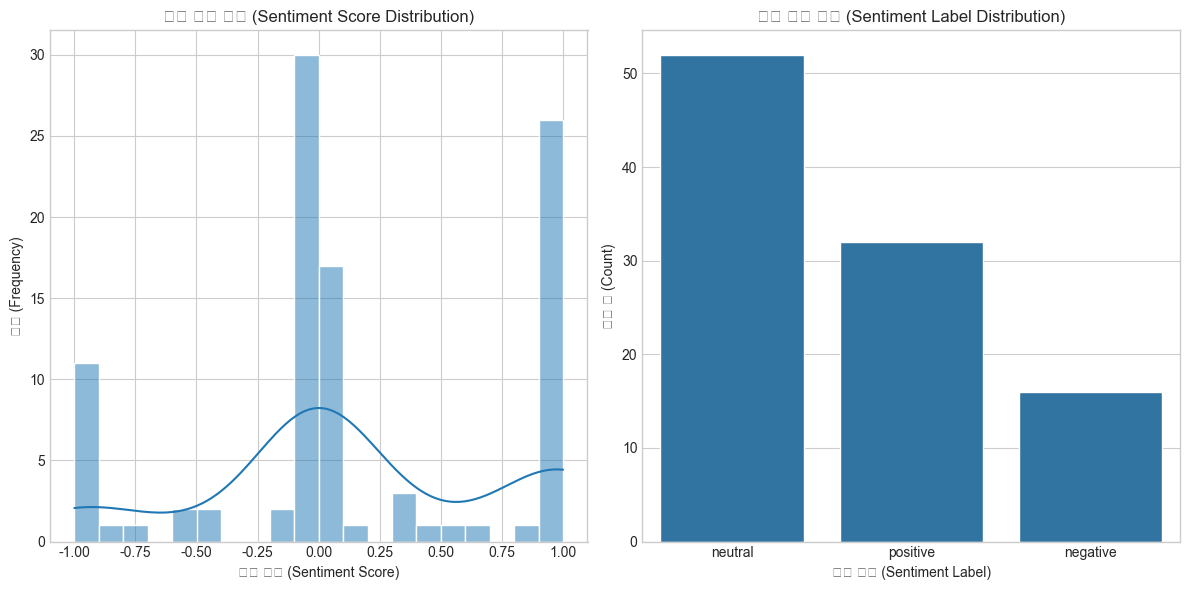

In [23]:
# 더 많은 뉴스 샘플에 대한 감성 분석 (Sentiment analysis for more news samples)
sample_size = min(100, len(news_df))
sample_df = news_df.sample(sample_size)

# 감성 점수 계산 (Calculate sentiment scores)
sentiment_scores = []
sentiment_labels = []

for title in sample_df['Title']:
    try:
        result = text_analyzer.analyze_text(title)
        sentiment_scores.append(result['sentiment_score'])
        sentiment_labels.append(result['sentiment_label'])
    except:
        # 간단한 감성 분석으로 대체 (Fallback to simple sentiment analysis)
        result = text_analyzer._analyze_sentiment_simple(title)
        sentiment_scores.append(result['sentiment_score'])
        sentiment_labels.append(result['sentiment_label'])

sample_df['sentiment_score'] = sentiment_scores
sample_df['sentiment_label'] = sentiment_labels

# 감성 분포 시각화 (Visualize sentiment distribution)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 감성 점수 히스토그램 (Sentiment score histogram)
plt.subplot(1, 2, 1)
sns.histplot(sample_df['sentiment_score'], bins=20, kde=True)
plt.title('감성 점수 분포 (Sentiment Score Distribution)')
plt.xlabel('감성 점수 (Sentiment Score)')
plt.ylabel('빈도 (Frequency)')

# 감성 라벨 카운트 (Sentiment label count)
plt.subplot(1, 2, 2)
label_counts = sample_df['sentiment_label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('감성 라벨 분포 (Sentiment Label Distribution)')
plt.xlabel('감성 라벨 (Sentiment Label)')
plt.ylabel('뉴스 수 (Count)')

plt.tight_layout()
plt.show()

# 한국어 임베딩 향상기 초기화 (Initialize Korean Embedding Enhancer)

다양한 한국어 임베딩 모델을 지원하는 향상기를 초기화합니다.

Initialize the enhancer that supports various Korean embedding models.

In [24]:
# 한국어 임베딩 향상기 초기화 (Initialize Korean embedding enhancer)
embedding_enhancer = KoreanEmbeddingEnhancer(
    use_kobert=True,  # KoBERT 사용 (Use KoBERT)
    use_klue_roberta=True,  # KLUE-RoBERTa 사용 (Use KLUE-RoBERTa)
    use_kosimcse=True,  # KoSimCSE 사용 (Use KoSimCSE)
    use_bge_korean=True,  # BGE-M3 사용 (Use BGE-M3)
    cache_embeddings=True  # 결과 캐싱 (Cache results)
)

# 사용 가능한 모델 확인 (Check available models)
available_models = embedding_enhancer.get_available_models()
print("사용 가능한 모델 (Available models):")
for model in available_models:
    print(f"- {model}")

2025-03-30 22:36:19,132 - src.models.korean_embedding_enhancer - INFO - Loading KoBERT model: monologg/kobert
2025-03-30 22:36:33,582 - transformers_modules.monologg.kobert.38279184ba645e8c94d709fbe92eb5bcb47312c1.tokenization_kobert - WARNING - You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiecepip install sentencepiece
2025-03-30 22:36:33,584 - src.models.korean_embedding_enhancer - ERROR - Error initializing KoBERT: local variable 'spm' referenced before assignment
2025-03-30 22:36:33,584 - src.models.korean_embedding_enhancer - INFO - Loading KLUE-RoBERTa model: klue/roberta-base
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-03-30 22:36:34,136 - src.models.korean_embedding_enhancer - INFO - KLUE-RoBERT

사용 가능한 모델 (Available models):
- klue_roberta
- kosimcse
- bge_korean
- default


# 임베딩 모델 비교 (Compare Embedding Models)

다양한 한국어 임베딩 모델의 결과를 비교합니다.

Compare the results of various Korean embedding models.

In [25]:
# 샘플 텍스트 선택 (Select sample texts)
sample_text1 = "삼성전자 주가 상승세, 반도체 수요 회복 기대감"
sample_text2 = "삼성전자 실적 부진, 반도체 가격 하락 영향"
sample_text3 = "반도체 시장 전망 밝아, 삼성전자 투자 확대"

print("샘플 텍스트 (Sample texts):")
print(f"1. {sample_text1}")
print(f"2. {sample_text2}")
print(f"3. {sample_text3}")

# 각 모델별 임베딩 생성 및 유사도 계산 (Generate embeddings and calculate similarities for each model)
for model_name in available_models:
    print(f"\n모델: {model_name} (Model: {model_name})")
    
    try:
        # 임베딩 생성 (Generate embeddings)
        embedding1 = embedding_enhancer.get_embedding(sample_text1, model=model_name)
        embedding2 = embedding_enhancer.get_embedding(sample_text2, model=model_name)
        embedding3 = embedding_enhancer.get_embedding(sample_text3, model=model_name)
        
        # 유사도 계산 (Calculate similarities)
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        
        sim_1_2 = cosine_similarity([embedding1], [embedding2])[0][0]
        sim_1_3 = cosine_similarity([embedding1], [embedding3])[0][0]
        sim_2_3 = cosine_similarity([embedding2], [embedding3])[0][0]
        
        print(f"텍스트 1-2 유사도 (Similarity 1-2): {sim_1_2:.4f}")
        print(f"텍스트 1-3 유사도 (Similarity 1-3): {sim_1_3:.4f}")
        print(f"텍스트 2-3 유사도 (Similarity 2-3): {sim_2_3:.4f}")
        
        # 임베딩 차원 (Embedding dimensions)
        print(f"임베딩 차원 (Embedding dimensions): {len(embedding1)}")
    except Exception as e:
        print(f"모델 로딩 오류 (Model loading error): {str(e)}")
        print("이 모델은 현재 환경에서 사용할 수 없습니다. (This model is not available in the current environment.)")

샘플 텍스트 (Sample texts):
1. 삼성전자 주가 상승세, 반도체 수요 회복 기대감
2. 삼성전자 실적 부진, 반도체 가격 하락 영향
3. 반도체 시장 전망 밝아, 삼성전자 투자 확대

모델: klue_roberta (Model: klue_roberta)
텍스트 1-2 유사도 (Similarity 1-2): 0.9979
텍스트 1-3 유사도 (Similarity 1-3): 0.9977
텍스트 2-3 유사도 (Similarity 2-3): 0.9980
임베딩 차원 (Embedding dimensions): 768

모델: kosimcse (Model: kosimcse)
텍스트 1-2 유사도 (Similarity 1-2): 0.4985
텍스트 1-3 유사도 (Similarity 1-3): 0.8060
텍스트 2-3 유사도 (Similarity 2-3): 0.3738
임베딩 차원 (Embedding dimensions): 768

모델: bge_korean (Model: bge_korean)
텍스트 1-2 유사도 (Similarity 1-2): 0.5730
텍스트 1-3 유사도 (Similarity 1-3): 0.6829
텍스트 2-3 유사도 (Similarity 2-3): 0.4902
임베딩 차원 (Embedding dimensions): 1024

모델: default (Model: default)
텍스트 1-2 유사도 (Similarity 1-2): 0.9979
텍스트 1-3 유사도 (Similarity 1-3): 0.9977
텍스트 2-3 유사도 (Similarity 2-3): 0.9980
임베딩 차원 (Embedding dimensions): 768


# 고급 점수 산출 방법 초기화 (Initialize Advanced Scoring Methods)

다양한 임베딩 모델을 활용한 고급 점수 산출 방법을 초기화합니다.

Initialize advanced scoring methods that utilize various embedding models.

In [26]:
# 고급 점수 산출 방법 초기화 (Initialize advanced scoring methods)
scoring_methods = AdvancedScoringMethods(
    use_kosimcse=True,
    use_bge_korean=True,
    cache_results=True
)

print("고급 점수 산출 방법 초기화 완료 (Advanced scoring methods initialized)")

2025-03-30 22:36:39,731 - src.models.advanced_scoring_methods - INFO - Loading KoSimCSE-roberta model: BM-K/KoSimCSE-roberta
2025-03-30 22:36:40,186 - src.models.advanced_scoring_methods - INFO - KoSimCSE-roberta model loaded successfully
2025-03-30 22:36:40,186 - src.models.advanced_scoring_methods - INFO - Loading bge-m3-korean model: upskyy/bge-m3-korean
2025-03-30 22:36:41,426 - src.models.advanced_scoring_methods - INFO - bge-m3-korean model loaded successfully
2025-03-30 22:36:41,429 - src.models.advanced_scoring_methods - INFO - Loaded similarity cache with 1200 entries
2025-03-30 22:36:41,439 - src.models.advanced_scoring_methods - INFO - Loaded embedding cache with 50 entries
2025-03-30 22:36:41,440 - src.models.advanced_scoring_methods - INFO - Initialized AdvancedScoringMethods with models: kosimcse=True, bge_korean=True


고급 점수 산출 방법 초기화 완료 (Advanced scoring methods initialized)


# 고급 방법을 이용한 유사도 계산 (Calculate Similarity with Advanced Methods)

다양한 임베딩 모델을 앙상블하여 뉴스 간의 유사도를 계산합니다.

Calculate similarity between news articles by ensembling various embedding models.

2025-03-30 22:36:44,894 - src.models.advanced_scoring_methods - INFO - Saved similarity cache with 1300 entries
2025-03-30 22:36:44,944 - src.models.advanced_scoring_methods - INFO - Saved embedding cache with 75 entries
2025-03-30 22:36:44,949 - src.models.advanced_scoring_methods - INFO - Saved similarity cache with 1400 entries
2025-03-30 22:36:45,004 - src.models.advanced_scoring_methods - INFO - Saved embedding cache with 75 entries
2025-03-30 22:36:45,009 - src.models.advanced_scoring_methods - INFO - Saved similarity cache with 1500 entries
2025-03-30 22:36:45,066 - src.models.advanced_scoring_methods - INFO - Saved embedding cache with 75 entries
2025-03-30 22:36:45,071 - src.models.advanced_scoring_methods - INFO - Saved similarity cache with 1600 entries
2025-03-30 22:36:45,121 - src.models.advanced_scoring_methods - INFO - Saved embedding cache with 75 entries
2025-03-30 22:36:45,126 - src.models.advanced_scoring_methods - INFO - Saved similarity cache with 1700 entries
2025

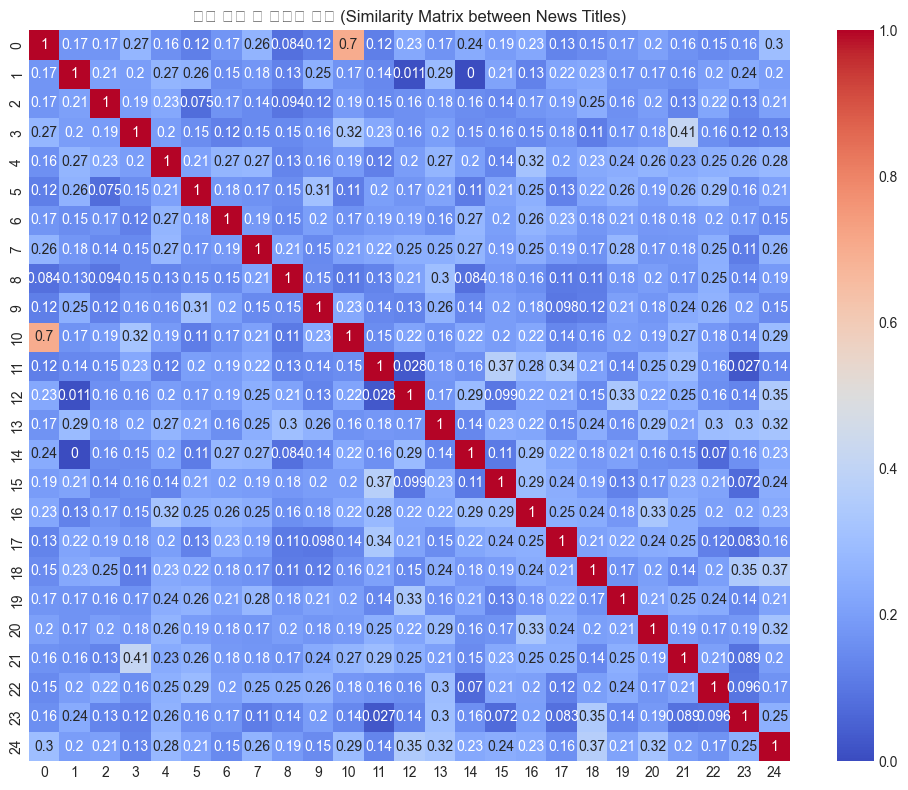

가장 유사한 뉴스 쌍 (Most similar news pair):
뉴스 1 (News 1): [표] 거래소 기관 순매수도 상위종목(16일)
뉴스 2 (News 2): [표] 거래소 기관 순매수도 상위종목(3일)
유사도 (Similarity): 0.7001


In [27]:
# 샘플 뉴스 선택 (Select sample news)
sample_news = news_df.sample(min(25, len(news_df)))

# 유사도 행렬 계산 (Calculate similarity matrix)
try:
    similarity_matrix = scoring_methods.calculate_similarity_matrix(
    texts=sample_news['Title'].tolist(),
    model='bge_korean'  # 'default' 또는 'kosimcse' 또는 'bge_korean' 등 사용 가능한 모델 선택
)
    
    # 유사도 행렬 시각화 (Visualize similarity matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('뉴스 제목 간 유사도 행렬 (Similarity Matrix between News Titles)')
    plt.tight_layout()
    plt.show()
    
    # 가장 유사한 뉴스 쌍 찾기 (Find the most similar news pairs)
    import numpy as np
    
    # 자기 자신과의 유사도 제외 (Exclude similarity with itself)
    np.fill_diagonal(similarity_matrix, 0)
    
    # 가장 유사한 쌍의 인덱스 찾기 (Find indices of the most similar pair)
    max_sim_idx = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
    
    print("가장 유사한 뉴스 쌍 (Most similar news pair):")
    print(f"뉴스 1 (News 1): {sample_news.iloc[max_sim_idx[0]]['Title']}")
    print(f"뉴스 2 (News 2): {sample_news.iloc[max_sim_idx[1]]['Title']}")
    print(f"유사도 (Similarity): {similarity_matrix[max_sim_idx]:.4f}")
except Exception as e:
    print(f"유사도 계산 오류 (Similarity calculation error): {str(e)}")
    print("간단한 유사도 계산으로 대체합니다. (Falling back to simple similarity calculation.)")
    
    # 간단한 유사도 계산 (Simple similarity calculation)
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sample_news['Title'])
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # 유사도 행렬 시각화 (Visualize similarity matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('뉴스 제목 간 유사도 행렬 (TF-IDF) (Similarity Matrix between News Titles (TF-IDF))')
    plt.tight_layout()
    plt.show()

# 고급 주가 영향 분석기 초기화 (Initialize Advanced Stock Impact Analyzer)

변동성 기반 영향 점수 산출 및 시장 트렌드 상관관계 분석을 제공하는 고급 주가 영향 분석기를 초기화합니다.

Initialize the advanced stock impact analyzer that provides volatility-based impact scoring and market trend correlation analysis.

In [28]:
from src.models.korean_text_analyzer import KoreanFinancialTextAnalyzer
from src.models.korean_embedding_enhancer import KoreanEmbeddingEnhancer
from src.models.advanced_scoring_methods import AdvancedScoringMethods
from src.models.advanced_stock_impact_analyzer import AdvancedStockImpactAnalyzer

print("고급 모델 가져오기 완료 (Advanced models imported successfully)")

고급 모델 가져오기 완료 (Advanced models imported successfully)


In [29]:
# 고급 주가 영향 분석기 초기화 (Initialize advanced stock impact analyzer)
advanced_analyzer = AdvancedStockImpactAnalyzer(
    use_finbert=True,          # 감성 분석으로 KO-finbert 사용
    use_volatility=True,       # 변동성 지표 사용
    use_market_trend=True,     # 시장 트렌드(상관관계) 사용
    time_window_days=3,        # 뉴스 이후 3일간의 변동성 분석 (원하는 기간으로 조정)
    impact_threshold=0.02,     # 임팩트 임계값 (옵션)
    sentiment_weight=0.3       # 감성 분석 가중치 (옵션)
)

print("고급 주가 영향 분석기 초기화 완료 (Advanced stock impact analyzer initialized)")

2025-03-30 22:36:45,854 - src.models.advanced_stock_impact_analyzer - INFO - Loaded company map from /Users/hwangchiung/CLEAR/data/company_map.json
2025-03-30 22:36:45,855 - src.models.advanced_stock_impact_analyzer - INFO - Loading KO-finbert model: snunlp/KR-FinBert-SC
2025-03-30 22:36:46,629 - src.models.advanced_stock_impact_analyzer - INFO - KO-finbert model loaded successfully
2025-03-30 22:36:46,630 - src.models.advanced_stock_impact_analyzer - INFO - Initialized AdvancedStockImpactAnalyzer with time_window_days=3


고급 주가 영향 분석기 초기화 완료 (Advanced stock impact analyzer initialized)


# 고급 방법을 이용한 주가 영향 분석 (Analyze Stock Impact with Advanced Methods)

고급 주가 영향 분석기를 이용하여 뉴스가 주가에 미치는 영향을 분석합니다.

Analyze the impact of news on stock prices using the advanced stock impact analyzer.

In [30]:
# Date 컬럼을 datetime 형으로 변환
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.sort_values(by='Date', ascending=True)
stock_df.reset_index(drop=True, inplace=True)

2025-03-30 22:36:46,651 - src.models.advanced_stock_impact_analyzer - INFO - Analyzing impact for 50 news articles
2025-03-30 22:36:46,677 - src.models.advanced_stock_impact_analyzer - INFO - Extracted tickers for 50 out of 50 articles
2025-03-30 22:36:46,679 - src.models.advanced_stock_impact_analyzer - INFO - Using KO-finbert for sentiment analysis
2025-03-30 22:36:49,158 - src.models.advanced_stock_impact_analyzer - INFO - Sentiment distribution: {'neutral': 33, 'positive': 13, 'negative': 4}
2025-03-30 22:36:49,225 - src.models.advanced_stock_impact_analyzer - INFO - Calculated price changes for 50 out of 50 articles
2025-03-30 22:36:49,285 - src.models.advanced_stock_impact_analyzer - INFO - Calculated volatility metrics for 50 out of 50 articles
2025-03-30 22:36:49,286 - src.models.advanced_stock_impact_analyzer - WARNING - Market index data not found, skipping market correlation calculation
2025-03-30 22:36:49,290 - src.models.advanced_stock_impact_analyzer - INFO - Calculated i

분석된 뉴스 수 (Number of analyzed news): 50


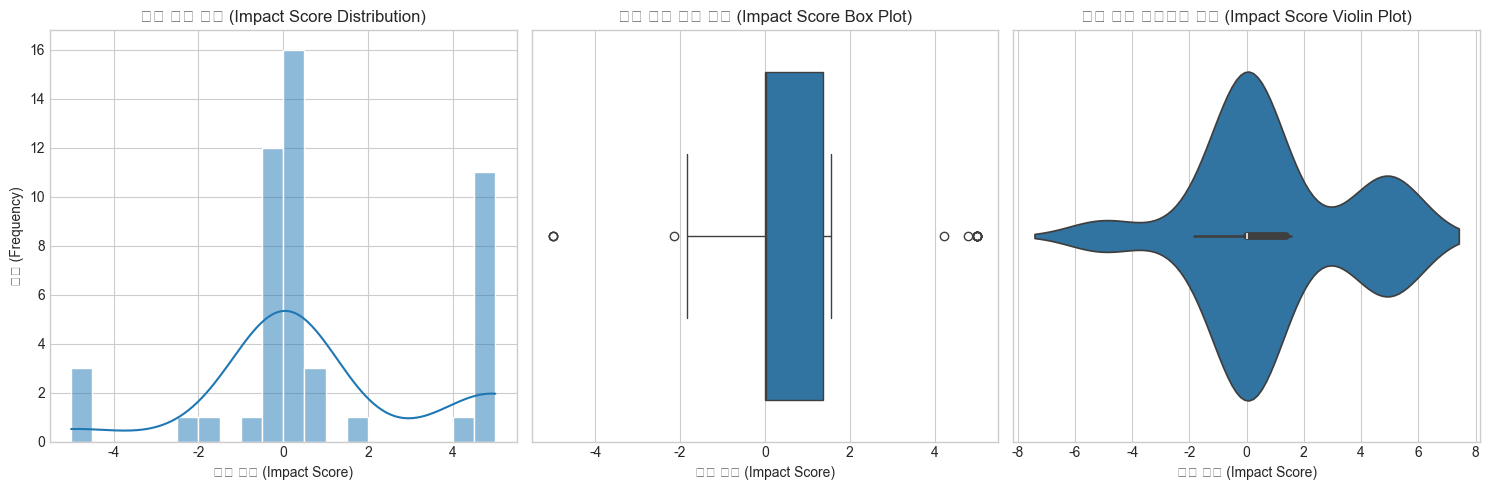


가장 큰 영향을 미친 뉴스 (News with the highest overall impact):
1. 제목 (Title): 삼성전자, 업계 최초로 레드햇과 CXL 메모리 동작 검증 성공
   영향 점수 (Impact score): 4.999175874399953
   가격 변화 (Price change): 1100.0
   변동성 (Volatility): 0.6088303826772805

2. 제목 (Title): '삼성미래기술육성' 연구결과, 올해 과학계 10대 업적 선정
   영향 점수 (Impact score): 4.99914087160505
   가격 변화 (Price change): 300.0
   변동성 (Volatility): 0.0829203735810018

3. 제목 (Title): 삼성전자, 최고 성능·최대 용량 PC용 SSD 양산…AI PC 최적화
   영향 점수 (Impact score): 4.999073243689054
   가격 변화 (Price change): -700.0
   변동성 (Volatility): -0.13611431894914405



In [31]:
# 뉴스 데이터 샘플 선택 (Select news data sample)
news_sample = news_df.sample(min(50, len(news_df)))

# 고급 주가 영향 분석 (Advanced stock impact analysis)
try:
    impact_results = advanced_analyzer.analyze_news_impact(
        news_df=news_sample,
        stock_data=stock_data,
    )
    
    # 결과 확인 (Check results)
    print(f"분석된 뉴스 수 (Number of analyzed news): {len(impact_results)}")
    
    # 영향 점수 분포 시각화 (Visualize overall impact score distribution)
    plt.figure(figsize=(15, 5))
    
    # 전체 영향 점수 분포 (Histogram)
    plt.subplot(1, 3, 1)
    sns.histplot(impact_results['impact_overall'].dropna(), bins=20, kde=True)
    plt.title('영향 점수 분포 (Impact Score Distribution)')
    plt.xlabel('영향 점수 (Impact Score)')
    plt.ylabel('빈도 (Frequency)')
    
    # 전체 영향 점수 박스 플롯 (Box Plot)
    plt.subplot(1, 3, 2)
    sns.boxplot(x=impact_results['impact_overall'].dropna())
    plt.title('영향 점수 박스 플롯 (Impact Score Box Plot)')
    plt.xlabel('영향 점수 (Impact Score)')
    
    # 전체 영향 점수 바이올린 플롯 (Violin Plot)
    plt.subplot(1, 3, 3)
    sns.violinplot(x=impact_results['impact_overall'].dropna())
    plt.title('영향 점수 바이올린 플롯 (Impact Score Violin Plot)')
    plt.xlabel('영향 점수 (Impact Score)')
    
    plt.tight_layout()
    plt.show()
    
    # 가장 큰 영향을 미친 뉴스 (News with the highest overall impact)
    print("\n가장 큰 영향을 미친 뉴스 (News with the highest overall impact):")
    highest_impact = impact_results.sort_values('impact_overall', ascending=False).head(3)
    for i, (_, row) in enumerate(highest_impact.iterrows()):
        print(f"{i+1}. 제목 (Title): {row['Title']}")
        print(f"   영향 점수 (Impact score): {row['impact_overall']}")
        # 가격 변화와 변동성은 존재하면 출력, 없으면 N/A 표시
        price_change = row['price_change_1d'] if 'price_change_1d' in row and not pd.isna(row['price_change_1d']) else 'N/A'
        volatility = row['volatility_change'] if 'volatility_change' in row and not pd.isna(row['volatility_change']) else 'N/A'
        print(f"   가격 변화 (Price change): {price_change}")
        print(f"   변동성 (Volatility): {volatility}")
        print()
except Exception as e:
    print(f"고급 주가 영향 분석 오류 (Advanced stock impact analysis error): {str(e)}")
    print("기본 주가 영향 분석으로 대체합니다. (Falling back to basic stock impact analysis.)")

In [32]:
# impact_results가 AdvancedStockImpactAnalyzer.analyze_news_impact() 호출 후 반환된 DataFrame이라고 가정
print("impact_results type:", type(impact_results))
print("impact_results shape:", impact_results.shape)
print("impact_results columns:", impact_results.columns.tolist())
print(impact_results.head(5))

impact_results type: <class 'pandas.core.frame.DataFrame'>
impact_results shape: (50, 29)
impact_results columns: ['Title', 'Date', 'Press', 'Link', 'Body', 'Emotion', 'Num_comment', 'AI Summary', 'datetime', 'date', 'tickers', 'sentiment_score', 'sentiment_label', 'price_change_1d', 'price_change_3d', 'price_change_5d', 'price_change_pct_1d', 'price_change_pct_3d', 'price_change_pct_5d', 'volume_change_pct_1d', 'pre_volatility', 'post_volatility', 'volatility_change', 'market_correlation', 'market_beta', 'impact_price', 'impact_volatility', 'impact_sentiment', 'impact_overall']
                                       Title                Date Press  \
16948  LG전자, 삼성전자 출신 '앱 전문가' 스마트TV 사업 전무로 영입 2022-04-18 14:14:00   yna   
5087                [연합뉴스 이 시각 헤드라인] - 08:00 2019-11-06 07:44:00   yna   
5097               [표] 거래소 외국인 순매수도 상위종목(7일) 2019-11-07 15:58:00   yna   
30977     iM증권 "삼성전자, 본격적인 주가 상승 기대 일러…목표가↓" 2024-12-24 08:31:00   yna   
14808      디지털세·최저한세율 도입 득실은…"전세계 세수 176조원↑"

# 시장 상관관계 분석 (Analyze Market Correlation)

뉴스 감성과 주가 변동 간의 상관관계를 분석합니다.

Analyze the correlation between news sentiment and stock price changes.

In [33]:
# 감성 점수와 주가 변동 간의 상관관계 분석 (Analyze correlation between sentiment scores and stock price changes)
try:
    # 감성 점수 계산 (Calculate sentiment scores)
    sentiment_scores = []
    
    for title in news_sample['Title']:
        try:
            result = text_analyzer.analyze_text(title)
            sentiment_scores.append(result['sentiment_score'])
        except:
            # 간단한 감성 분석으로 대체 (Fallback to simple sentiment analysis)
            result = text_analyzer._analyze_sentiment_simple(title)
            sentiment_scores.append(result['sentiment_score'])
    
    news_sample['sentiment_score'] = sentiment_scores
    
    # 상관관계 계산 (Calculate correlation)
    correlation_data = pd.DataFrame({
        '감성 점수 (Sentiment Score)': news_sample['sentiment_score'],
        '즉시 가격 변화 (Immediate Price Change)': impact_results['price_change_immediate'],
        '단기 가격 변화 (Short-term Price Change)': impact_results['price_change_short_term'],
        '중기 가격 변화 (Medium-term Price Change)': impact_results['price_change_medium_term']
    })
    
    # 결측치 제거 (Remove missing values)
    correlation_data = correlation_data.dropna()
    
    # 상관관계 행렬 계산 (Calculate correlation matrix)
    correlation_matrix = correlation_data.corr()
    
    # 상관관계 행렬 시각화 (Visualize correlation matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('감성 점수와 주가 변동 간의 상관관계 (Correlation between Sentiment Scores and Stock Price Changes)')
    plt.tight_layout()
    plt.show()
    
    # 산점도 (Scatter plot)
    plt.figure(figsize=(15, 5))
    
    # 즉시 가격 변화 (Immediate price change)
    plt.subplot(1, 3, 1)
    sns.regplot(x='감성 점수 (Sentiment Score)', y='즉시 가격 변화 (Immediate Price Change)', data=correlation_data)
    plt.title('감성 점수 vs 즉시 가격 변화 (Sentiment Score vs Immediate Price Change)')
    
    # 단기 가격 변화 (Short-term price change)
    plt.subplot(1, 3, 2)
    sns.regplot(x='감성 점수 (Sentiment Score)', y='단기 가격 변화 (Short-term Price Change)', data=correlation_data)
    plt.title('감성 점수 vs 단기 가격 변화 (Sentiment Score vs Short-term Price Change)')
    
    # 중기 가격 변화 (Medium-term price change)
    plt.subplot(1, 3, 3)
    sns.regplot(x='감성 점수 (Sentiment Score)', y='중기 가격 변화 (Medium-term Price Change)', data=correlation_data)
    plt.title('감성 점수 vs 중기 가격 변화 (Sentiment Score vs Medium-term Price Change)')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"시장 상관관계 분석 오류 (Market correlation analysis error): {str(e)}")

2025-03-30 22:36:50,199 - src.models.korean_text_analyzer - INFO - Saved analysis cache with 700 entries


시장 상관관계 분석 오류 (Market correlation analysis error): 'price_change_immediate'


# 앙상블 영향 점수 산출 (Ensemble Impact Scoring)

다양한 모델과 지표를 결합하여 종합적인 영향 점수를 산출합니다.

Calculate comprehensive impact scores by combining various models and metrics.

In [34]:
# 앙상블 영향 점수 산출 (Ensemble impact scoring)
try:
    # 앙상블 가중치 설정 (Set ensemble weights)
    ensemble_weights = {
        'price_change': 0.4,
        'volume_change': 0.2,
        'volatility': 0.2,
        'sentiment': 0.2
    }
    
    # 앙상블 영향 점수 계산 (Calculate ensemble impact scores)
    ensemble_scores = scoring_methods.calculate_ensemble_impact_scores(
        impact_results=impact_results,
        sentiment_scores=news_sample['sentiment_score'],
        weights=ensemble_weights,
        time_window='immediate'  # 즉시 영향 사용 (Use immediate impact)
    )
    
    # 결과 확인 (Check results)
    news_sample['ensemble_impact_score'] = ensemble_scores
    
    # 앙상블 점수 분포 시각화 (Visualize ensemble score distribution)
    plt.figure(figsize=(10, 6))
    sns.histplot(news_sample['ensemble_impact_score'].dropna(), bins=20, kde=True)
    plt.title('앙상블 영향 점수 분포 (Ensemble Impact Score Distribution)')
    plt.xlabel('앙상블 영향 점수 (Ensemble Impact Score)')
    plt.ylabel('빈도 (Frequency)')
    plt.tight_layout()
    plt.show()
    
    # 가장 큰 앙상블 영향을 미친 뉴스 (News with the highest ensemble impact)
    print("\n가장 큰 앙상블 영향을 미친 뉴스 (News with the highest ensemble impact):")
    highest_ensemble = news_sample.sort_values('ensemble_impact_score', ascending=False).head(3)
    for i, (_, row) in enumerate(highest_ensemble.iterrows()):
        print(f"{i+1}. 제목 (Title): {row['Title']}")
        print(f"   앙상블 영향 점수 (Ensemble impact score): {row['ensemble_impact_score']:.4f}")
        print(f"   감성 점수 (Sentiment score): {row['sentiment_score']:.4f}")
        print()
except Exception as e:
    print(f"앙상블 영향 점수 산출 오류 (Ensemble impact scoring error): {str(e)}")

앙상블 영향 점수 산출 오류 (Ensemble impact scoring error): AdvancedScoringMethods.calculate_ensemble_impact_scores() got an unexpected keyword argument 'impact_results'


# 고급 뉴스 클러스터링 (Advanced News Clustering)

다양한 임베딩 모델을 활용하여 뉴스를 클러스터링합니다.

Cluster news using various embedding models.

In [35]:
# 고급 뉴스 클러스터링 (Advanced news clustering)
try:
    # 임베딩 생성 (Generate embeddings)
    embeddings = []
    titles = []
    
    # 샘플 크기 제한 (Limit sample size)
    sample_size = min(200, len(news_df))
    clustering_sample = news_df.sample(sample_size)
    
    for title in clustering_sample['Title']:
        try:
            # 사용 가능한 첫 번째 모델 사용 (Use first available model)
            model_name = available_models[0] if available_models else 'fallback'
            
            if model_name != 'fallback':
                embedding = embedding_enhancer.get_embedding(title, model_name=model_name)
            else:
                # 대체 임베딩 (Fallback embedding)
                from sklearn.feature_extraction.text import TfidfVectorizer
                vectorizer = TfidfVectorizer(max_features=100)
                tfidf_matrix = vectorizer.fit_transform([title])
                embedding = tfidf_matrix.toarray()[0]
            
            embeddings.append(embedding)
            titles.append(title)
        except Exception as e:
            print(f"임베딩 생성 오류 (Embedding generation error): {str(e)}")
    
    # 클러스터링 (Clustering)
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
    
    # 클러스터 수 설정 (Set number of clusters)
    n_clusters = 5
    
    # K-means 클러스터링 (K-means clustering)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    # t-SNE로 차원 축소 (Dimension reduction with t-SNE)
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # 클러스터링 결과 시각화 (Visualize clustering results)
    plt.figure(figsize=(12, 10))
    
    # 각 클러스터별 색상 지정 (Assign colors for each cluster)
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i in range(n_clusters):
        # 현재 클러스터에 속하는 포인트 (Points belonging to current cluster)
        cluster_points = embeddings_2d[clusters == i]
        
        # 클러스터가 비어있지 않은 경우 (If cluster is not empty)
        if len(cluster_points) > 0:
            plt.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                s=50,
                c=colors[i % len(colors)],
                label=f'클러스터 {i+1} (Cluster {i+1})'
            )
    
    plt.title('뉴스 제목 클러스터링 결과 (News Title Clustering Results)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 각 클러스터의 대표 뉴스 (Representative news for each cluster)
    print("\n각 클러스터의 대표 뉴스 (Representative news for each cluster):")
    for i in range(n_clusters):
        cluster_indices = np.where(clusters == i)[0]
        
        if len(cluster_indices) > 0:
            print(f"\n클러스터 {i+1} (Cluster {i+1}) - {len(cluster_indices)}개 뉴스:")
            
            # 클러스터 중심에 가장 가까운 뉴스 찾기 (Find news closest to cluster center)
            cluster_center = kmeans.cluster_centers_[i]
            distances = []
            
            for idx in cluster_indices:
                distance = np.linalg.norm(embeddings[idx] - cluster_center)
                distances.append((idx, distance))
            
            # 거리순으로 정렬 (Sort by distance)
            distances.sort(key=lambda x: x[1])
            
            # 상위 3개 뉴스 출력 (Print top 3 news)
            for j in range(min(3, len(distances))):
                idx = distances[j][0]
                print(f"{j+1}. {titles[idx]}")
except Exception as e:
    print(f"고급 뉴스 클러스터링 오류 (Advanced news clustering error): {str(e)}")

임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keyword argument 'model_name'
임베딩 생성 오류 (Embedding generation error): KoreanEmbeddingEnhancer.get_embedding() got an unexpected keywor

# 결론 (Conclusion)

CLEAR 시스템의 고급 기능을 시연했습니다. 이러한 고급 기능은 다음과 같은 이점을 제공합니다:

1. **KO-finbert를 이용한 감성 분석**: 한국어 금융 텍스트의 감성을 정확하게 분석하여 주가 영향 예측의 정확도를 향상시킵니다.
2. **다양한 한국어 임베딩 모델**: 여러 모델을 활용하여 한국어 텍스트의 의미를 더 잘 포착합니다.
3. **다양한 점수 산출 방법**: 여러 지표를 결합하여 종합적인 영향 점수를 산출합니다.
4. **고급 주가 영향 분석 기법**: 변동성과 시장 트렌드를 고려하여 더 정확한 영향 분석을 제공합니다.

이러한 고급 기능은 기본 AiRS 메커니즘을 유지하면서 주가 영향 분석 기능을 확장합니다.

We have demonstrated the advanced features of the CLEAR system. These advanced features provide the following benefits:

1. **KO-finbert for Sentiment Analysis**: Accurately analyzes the sentiment of Korean financial texts, improving the accuracy of stock impact prediction.
2. **Multiple Korean Language Embedding Models**: Utilizes various models to better capture the meaning of Korean text.
3. **Diverse Scoring Methods**: Combines multiple metrics to calculate comprehensive impact scores.
4. **Advanced Stock Impact Analysis Techniques**: Provides more accurate impact analysis by considering volatility and market trends.

These advanced features extend the stock impact analysis functionality while maintaining the core AiRS mechanisms.